# Artificial Neural Network and Deep Learning - Challenge 1

## Hyperparameters

In [ ]:
############################################################

SEED = 100
USE_SEED = True

# Training
EPOCHS = 300                        # Maximum epochs (increase to improve performance)
PATIENCE = 50                       # Early stopping patience (increase to improve performance)
VERBOSE = 1                         # Print printing frequency
VALIDATION_SPLIT = 0.2              # Validation split ratio


############################################################
# General Paremeters
############################################################

# Loss Function
CROSS_ENTROPY_WEIGHTING = True      # Enable or disable class weighting
WEIGHT_CE_INTENSITY = 1.6           # Intensity of class weighting (higher values increase the effect)
LABEL_SMOOTHING_EPSILON = 0.00       # Label smoothing epsilon (0.0 to disable)

# Optimisation
LEARNING_RATE = 0.001               # Learning rate
BATCH_SIZE = 64                     # Batch size
WINDOW_SIZE = 40                    # Input window size
STRIDE = 20                         # Input stride

# Regularisation
NOISE_STD_DEV = 0.2                 # Data Augmentation: Added noise on training dataset
DROPOUT_RATE = 0.4                 # Dropout probability
L1_LAMBDA = 0.0                     # L1 penalty
L2_LAMBDA = 0.2                    # L2 penalty

############################################################
# MODEL ARCHITECTURE
############################################################

# Branch 1 CONFIGURATION 
HIDDEN_LAYERS = 2                   # Hidden layers
HIDDEN_SIZE = 8                    # Neurons per layer
RNN_TYPE = 'LSTM'                   # Type of RNN architecture ['RNN', 'LSTM', 'GRU']
BIDIRECTIONAL = True                # Bidirectional RNN
PAIN_EMBEDDING_DIM = 3              # Dimension of pain embedding

# Branch 2 CONFIGURATION 
STATIC_HIDDEN_SIZE = 4             # Size of the new MLP branch
STATIC_EMBEDDING_DIM = 3            # Dimension of static features embedding

############################################################
# TRAINING MODE AND OPTIONS
############################################################

# Select only one of the following training modes
NORMAL_TRAINING = False
CROSS_VALIDATION_TRAINING = True
GRID_SEARCH = False
BAYESIAN_SEARCH = False
FULL_DATASET_TRAINING = False
ENSEMBLE_TRAINING = False            


# --- CROSS-VALIDATION CONFIGURATION ---
K = 5                               # Number of splits for K-Fold CV
VERBOSE_CV_RUN = 10                 # Set to 1 to see epoch-by-epoch in CV


# --- FULL DATASET TRAINING CONFIGURATION ---
OPTIMAL_EPOCHS =  182                # Optimal epochs determined from CV


############################################################
# NOTE; DOESNT WORK  Bayesian Search Hyperparameter Ranges 

BS_N_TRIALS = 100

# === Float Ranges [min, max] ===
# Note: BS_L2_LAMBDA min is set to 1e-5 as log scale cannot start from 0.
# BS_LEARNING_RATE = [1e-5, 1e-2]
# BS_L2_LAMBDA = [1e-5, 1e-2]

# BS_WEIGHT_CE_INTENSITY = [0.0, 2.0]
# BS_DROPOUT_RATE = [0.0, 0.5]
# BS_LABEL_SMOOTHING = [0.0, 0.1]
# BS_NOISE_STD_DEV = [0.0, 0.2]

# # === Categorical Lists ===
# BS_BATCH_SIZE = [32, 64, 128]
# BS_WINDOW_SIZE = [40, 80, 120]
# BS_STRIDE = [20, 40]
# BS_HIDDEN_SIZE = [32, 64, 128]
# BS_PAIN_HIDDEN_SIZE = [16, 32, 64]
# BS_STATIC_HIDDEN_SIZE = [16, 32, 64]
# BS_HIDDEN_LAYERS = [1, 3]
# BS_PAIN_NUM_LAYERS = [1, 2]
# BS_RNN_TYPE = ['LSTM', 'GRU']

# # --- Parameters to keep fixed ---
# BS_BIDIRECTIONAL = [BIDIRECTIONAL] 
# BS_PAIN_BRANCH_TYPE = [PAIN_BRANCH_TYPE]
# BS_PAIN_BRANCH_BIDIRECTIONAL = [PAIN_BRANCH_BIDIRECTIONAL]

############################################################


## Libraries and dataset import

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import random
import torch
import os
import sys
from itertools import product
from itertools import chain
import optuna

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
import torch.nn as nn
from datetime import datetime 
import hashlib

import torch.nn.functional as F
from IPython.display import display, clear_output


if USE_SEED:
    print(f"Using fixed random seed: {SEED}")
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
else:
    print("Running with random seed.")


if torch.cuda.is_available():
    device = torch.device("cuda")
    if USE_SEED:
        torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

df_train = pd.read_csv('pirate_pain_train.csv')
df_labels = pd.read_csv('pirate_pain_train_labels.csv')




Using fixed random seed: 100
PyTorch version: 2.9.0+cu128
Device: cuda


## Preprocessing

### Windows Creation

In [277]:

# =============================================================================
# --- 1. CLASS DEFINITIONS ---
# =============================================================================

class PainDataset(Dataset):
    """
    Custom PyTorch Dataset that handles the 3-input model:
    (X_rnn, X_pain, X_static)
    
    FIX: Now handles X_static as torch.long for categorical embeddings.
    """
    def __init__(self, X_rnn, X_pain, y, window_sample_indices, static_df,
                 is_train=False, n_joint_cols=0, noise_level=0.01):
        
        self.X_rnn = torch.tensor(X_rnn, dtype=torch.float32)
        self.X_pain = torch.tensor(X_pain, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
        self.window_sample_indices = window_sample_indices
        
        self.static_data = torch.tensor(static_df.values, dtype=torch.long)
        self.static_map = {sid: i for i, sid in enumerate(static_df.index)}
        
        self.is_train = is_train
        self.n_joint_cols = n_joint_cols 
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x_rnn_sample = self.X_rnn[idx].clone()
        x_pain_sample = self.X_pain[idx]
        y_sample = self.y[idx]
        
        # Apply noise only to the original joint features, not derivatives
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_rnn_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_rnn_sample[:, :self.n_joint_cols] = x_rnn_sample[:, :self.n_joint_cols] + noise.to(x_rnn_sample.device)
        
        # Look up the corresponding static features for this window
        sample_index = self.window_sample_indices[idx]
        static_idx_lookup = self.static_map.get(sample_index)
        
        if static_idx_lookup is None:
            # This should not happen if df_static_final is correct
            print(f"Warning: Missing static data for sample_index {sample_index}. Returning zeros.")
            # --- FIX: Must return torch.long ---
            x_static_sample = torch.zeros(self.static_data.shape[1], dtype=torch.long)
        else:
            x_static_sample = self.static_data[static_idx_lookup] # This is now torch.long
            
        # Return a tuple of three inputs
        return (x_rnn_sample, x_pain_sample, x_static_sample), y_sample

# =============================================================================
# --- 2. FUNCTION DEFINITIONS ---
# =============================================================================

def define_feature_columns(df_train):
    """
    Identifies and returns lists of columns for each data branch.
    """
    print("Defining feature columns...")
    
    original_joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
    original_joint_cols = original_joint_cols[:-1]
    
    pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
    static_cols_raw = [c for c in df_train.columns if c.startswith('n_')]

    # Branch 1: Main RNN input (30 features)
    temporal_cols_rnn = original_joint_cols
    input_size_rnn = len(temporal_cols_rnn)

    # Branch 2: Pain RNN/MLP input (4 features)
    input_size_pain = len(pain_cols)

    # Create label map
    label_map = {"no_pain": 0, "low_pain": 1, "high_pain": 2}
    inv_label_map = {v: k for k, v in label_map.items()}

    print(f"Branch 1 (RNN) Input Features: {input_size_rnn} (Joints)")
    print(f"Branch 2 (Pain) Input Features: {input_size_pain} (Surveys)")
    print(f"Found Raw Static Feature columns: {static_cols_raw}")
    
    return (
        original_joint_cols, pain_cols, static_cols_raw, 
        temporal_cols_rnn, label_map, inv_label_map
    )

def split_data(df_train, df_labels, test_size, random_state):
    """
    Splits data by unique sample_index to prevent data leakage.
    (This function is unchanged)
    """
    print(f"Splitting data by sample_index (Test Size: {test_size})...")
    unique_sids = df_labels['sample_index'].unique()
    
    train_sids, val_sids = train_test_split(
        unique_sids,
        test_size=test_size,
        random_state=random_state,
        stratify=df_labels['label']
    )
    
    df_train_split = df_train[df_train['sample_index'].isin(train_sids)]
    df_labels_train_split = df_labels[df_labels['sample_index'].isin(train_sids)]
    df_val_split = df_train[df_train['sample_index'].isin(val_sids)]
    df_labels_val_split = df_labels[df_labels['sample_index'].isin(val_sids)]
    
    return (
        df_train_split, df_labels_train_split, 
        df_val_split, df_labels_val_split,
        train_sids, val_sids
    )

def engineer_static_features(raw_df):
    """
    Engineers the raw static features into 0-indexed integer categories.
    
    FIX: Maps '1' -> 0 and '2' -> 1.
    This is CRITICAL for nn.Embedding, which needs 0-indexed data.
    """
    engineered_df = pd.DataFrame(index=raw_df.index)
    
    # --- FIX: Map '1' to 0 and '2' to 1 ---
    if 'n_legs' in raw_df:
        engineered_df['n_legs'] = np.where(raw_df['n_legs'] == '2', 1, 0)
    if 'n_hands' in raw_df:
        engineered_df['n_hands'] = np.where(raw_df['n_hands'] == '2', 1, 0)
    if 'n_eyes' in raw_df:
        engineered_df['n_eyes'] = np.where(raw_df['n_eyes'] == '2', 1, 0)
        
    return engineered_df

def get_normalization_stats(df_train_split, rnn_cols, pain_cols, static_cols_raw):
    """
    Calculates normalization stats for RNN and vocab stats for categorical features.

    """
    print("\nCalculating global normalization/vocab stats from training data...")
    
    # --- Joints (Unchanged) ---
    train_temporal_data = df_train_split[rnn_cols].values
    global_temporal_min = np.min(train_temporal_data, axis=0)
    global_temporal_max = np.max(train_temporal_data, axis=0)
    print(f"Global temporal min/max shape: {global_temporal_min.shape}")

    # --- Pain (FIX: No longer needed, as it's categorical) ---
    # (We assume PAIN_SIZE is calculated elsewhere, e.g., max(score)+1)
    print("Pain features are categorical (handled by build_fixed_sequences).")

    # --- Static (FIX: Calculate vocab sizes, NOT min/max) ---
    print("Starting static feature engineering (for vocab stats)...")
    df_static_raw_train = df_train_split.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw]
    
    # Use our NEW 0-indexed engineer_static_features function
    df_static_engineered_train = engineer_static_features(df_static_raw_train)
    # --- FIX: Fill NaNs with a valid index, e.g., 1 (for '2') ---
    df_static_engineered_train = df_static_engineered_train.fillna(1) 
    print("Engineering complete.")

    static_features_list = list(df_static_engineered_train.columns)
    
    # --- FIX: Calculate the vocab size for EACH static column ---
    # This finds the max index (e.g., 1) and adds 1 to get the vocab size (e.g., 2)
    static_vocab_size = [int(df_static_engineered_train[c].max() + 1) for c in static_features_list]
    
    print(f"Static features list: {static_features_list}")
    print(f"Static vocab sizes (e.g., max_index + 1): {static_vocab_size}")

    # Return stats in a dictionary for clarity
    stats = {
        'temporal_min': global_temporal_min,
        'temporal_max': global_temporal_max,
        'static_features_list': static_features_list,
        'static_vocab_size': static_vocab_size # Model will need this!
    }
    return stats


def build_fixed_sequences(df_features, df_labels, 
                          rnn_cols, pain_cols, label_map,
                          temporal_min, temporal_max,
                          window=200, stride=50):
    """
    Builds windowed sequences.
    (This is the version you already fixed, which correctly
    handles pain features as categorical. It is unchanged.)
    """
    dataset_rnn = []
    dataset_pain = []
    labels = []
    sample_indices = []
    
    n_features_rnn = len(rnn_cols)
    n_features_pain = len(pain_cols)

    print(f"Building fixed sequences (for EMBEDDING) with window={window}, stride={stride}...")
    
    temporal_range = temporal_max - temporal_min
    temporal_range[temporal_range == 0] = 1
    temporal_min_tensor = torch.FloatTensor(temporal_min)
    temporal_range_tensor = torch.FloatTensor(temporal_range)


    for sid in df_features['sample_index'].unique():
        temp_df = df_features[df_features['sample_index'] == sid].sort_values('time')
        temp_features_rnn = temp_df[rnn_cols].values
        temp_features_pain = temp_df[pain_cols].values
        
        label_str = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
        label_numeric = label_map[label_str]

        rnn_data_tensor = torch.FloatTensor(temp_features_rnn)
        normalized_rnn = 2 * ((rnn_data_tensor - temporal_min_tensor) / temporal_range_tensor) - 1
        temp_features_rnn_norm = normalized_rnn.numpy()
        
        temp_features_rnn_padded = temp_features_rnn_norm
        temp_features_pain_padded = temp_features_pain 

        idx = 0
        while idx + window <= len(temp_features_rnn_padded):
            dataset_rnn.append(temp_features_rnn_padded[idx:idx + window])
            dataset_pain.append(temp_features_pain_padded[idx:idx + window])
            labels.append(label_numeric)
            sample_indices.append(sid)
            idx += stride

    dataset_rnn = np.array(dataset_rnn, dtype=np.float32)
    dataset_pain = np.array(dataset_pain, dtype=np.int64)
    labels = np.array(labels, dtype=np.int64)

    return (dataset_rnn, dataset_pain), labels, np.array(sample_indices)

def create_final_static_indices_df(df_train, static_cols_raw, static_features_list):
    """
    Engineers the static features into integer indices for the *entire* dataset.
    
    FIX: This function NO LONGER normalizes. It just engineers and fills NaNs.
    """
    print("\nStarting final static feature *index* engineering...")
    df_static_raw = df_train.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw]
    
    # Use our NEW 0-indexed engineer_static_features function
    df_static_engineered = engineer_static_features(df_static_raw)
    print("Engineering complete.")

    # --- FIX: Fill NaNs with a valid index, e.g., 1 (for '2') ---
    # Ensure column order is correct
    df_static_final = df_static_engineered.fillna(1)[static_features_list]
    print(f"Created final static *index* features for {len(df_static_final)} samples.")

    # --- FIX: REMOVED ALL NORMALIZATION LOGIC ---
    
    return df_static_final 

def create_dataloaders(df_train_split, df_labels_train_split,
                       df_val_split, df_labels_val_split,
                       rnn_cols, pain_cols, label_map,
                       stats_dict, 
                       df_static_indices, # <-- FIX: Renamed for clarity
                       window_size, stride, batch_size, noise_std_dev,
                       original_joint_cols):
    """
    Builds sequences and creates the final Train and Val DataLoaders.
    
    FIX: Passes the new df_static_indices to PainDataset.
    FIX: Removed pain_min/max from build_fixed_sequences calls.
    """
    
    # --- 1. Build Training sequences ---
    (X_train_rnn, X_train_pain), y_train, train_window_sids = build_fixed_sequences(
        df_train_split, df_labels_train_split,
        rnn_cols, pain_cols, label_map,
        temporal_min=stats_dict['temporal_min'],
        temporal_max=stats_dict['temporal_max'],
        # --- FIX: Removed pain_min/max ---
        window=window_size,
        stride=stride
    )
    
    # --- 2. Build Validation sequences ---
    (X_val_rnn, X_val_pain), y_val, val_window_sids = build_fixed_sequences(
        df_val_split, df_labels_val_split,
        rnn_cols, pain_cols, label_map,
        temporal_min=stats_dict['temporal_min'],
        temporal_max=stats_dict['temporal_max'],
        # --- FIX: Removed pain_min/max ---
        window=window_size,
        stride=stride
    )
    
    print(f"\nTotal windows created (Train): {len(y_train)}")
    print(f"Total windows created (Val):   {len(y_val)}")
    print(f"Shape of X_train_rnn: {X_train_rnn.shape}") 

    # --- 3. Create Datasets ---
    n_joint_cols_original = len(original_joint_cols) 

    train_dataset = PainDataset(
        X_train_rnn, X_train_pain, y_train, train_window_sids, 
        df_static_indices, # <-- FIX: Pass the integer dataframe
        is_train=True,
        n_joint_cols=n_joint_cols_original, 
        noise_level=noise_std_dev
    )
    val_dataset = PainDataset(
        X_val_rnn, X_val_pain, y_val, val_window_sids, 
        df_static_indices, # <-- FIX: Pass the integer dataframe
        is_train=False
    )

    # --- 4. Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("\n--- Data Pipeline Complete ---")
    print(f"Train loader has {len(train_loader)} batches.")
    print(f"Validation loader has {len(val_loader)} batches.")
    
    return train_loader, val_loader

# =============================================================================
# --- 3. MAIN EXECUTION BLOCK ---
# =============================================================================

# --- 1. Define Columns ---
(
    original_joint_cols, pain_cols, static_cols_raw, 
    temporal_cols_rnn, label_map, inv_label_map
) = define_feature_columns(df_train)

# --- 2. Split Data ---
(
    df_train_split, df_labels_train_split, 
    df_val_split, df_labels_val_split,
    train_sids, val_sids
) = split_data(df_train, df_labels, VALIDATION_SPLIT, SEED)

# --- 3. Get Normalization Stats (from Train split ONLY) ---
stats_dict = get_normalization_stats(
    df_train_split, 
    temporal_cols_rnn, 
    pain_cols, 
    static_cols_raw
)

GLOBAL_TEMPORAL_MIN = stats_dict['temporal_min']
GLOBAL_TEMPORAL_MAX = stats_dict['temporal_max']
# -----------------------------------------------------------

# --- 4. Create Final Static DFs (for ALL data) ---
df_static_indices = create_final_static_indices_df(
    df_train,  # Use the *full* df_train to get static info for all samples
    static_cols_raw,
    stats_dict['static_features_list']
    # --- FIX: No longer needs min/max ---
)

# --- 5. Create DataLoaders ---
train_loader, val_loader = create_dataloaders(
    df_train_split, df_labels_train_split,
    df_val_split, df_labels_val_split,
    temporal_cols_rnn, pain_cols, label_map,
    stats_dict, # Pass the whole dict
    df_static_indices, # <-- FIX: Pass the new integer dataframe
    WINDOW_SIZE, STRIDE, BATCH_SIZE, NOISE_STD_DEV,
    original_joint_cols
)

# --- 6. Final Check ---
(x_rnn_batch, x_pain_batch, x_static_batch), y_batch = next(iter(train_loader))
print(f"RNN batch shape:   {x_rnn_batch.shape} (dtype: {x_rnn_batch.dtype})")
print(f"Pain batch shape:  {x_pain_batch.shape} (dtype: {x_pain_batch.dtype})")
print(f"Static batch shape: {x_static_batch.shape} (dtype: {x_static_batch.dtype})") # <-- This should now be torch.long
print(f"Label batch shape: {y_batch.shape} (dtype: {y_batch.dtype})")

Defining feature columns...
Branch 1 (RNN) Input Features: 30 (Joints)
Branch 2 (Pain) Input Features: 4 (Surveys)
Found Raw Static Feature columns: ['n_legs', 'n_hands', 'n_eyes']
Splitting data by sample_index (Test Size: 0.2)...

Calculating global normalization/vocab stats from training data...
Global temporal min/max shape: (30,)
Pain features are categorical (handled by build_fixed_sequences).
Starting static feature engineering (for vocab stats)...
Engineering complete.
Static features list: ['n_legs', 'n_hands', 'n_eyes']
Static vocab sizes (e.g., max_index + 1): [1, 1, 1]

Starting final static feature *index* engineering...
Engineering complete.
Created final static *index* features for 661 samples.
Building fixed sequences (for EMBEDDING) with window=40, stride=20...
Building fixed sequences (for EMBEDDING) with window=40, stride=20...

Total windows created (Train): 3696
Total windows created (Val):   931
Shape of X_train_rnn: (3696, 40, 30)

--- Data Pipeline Complete ---


--- Plotting a single sample's features ---
Plotting sample_index: 7 (Label: no_pain)


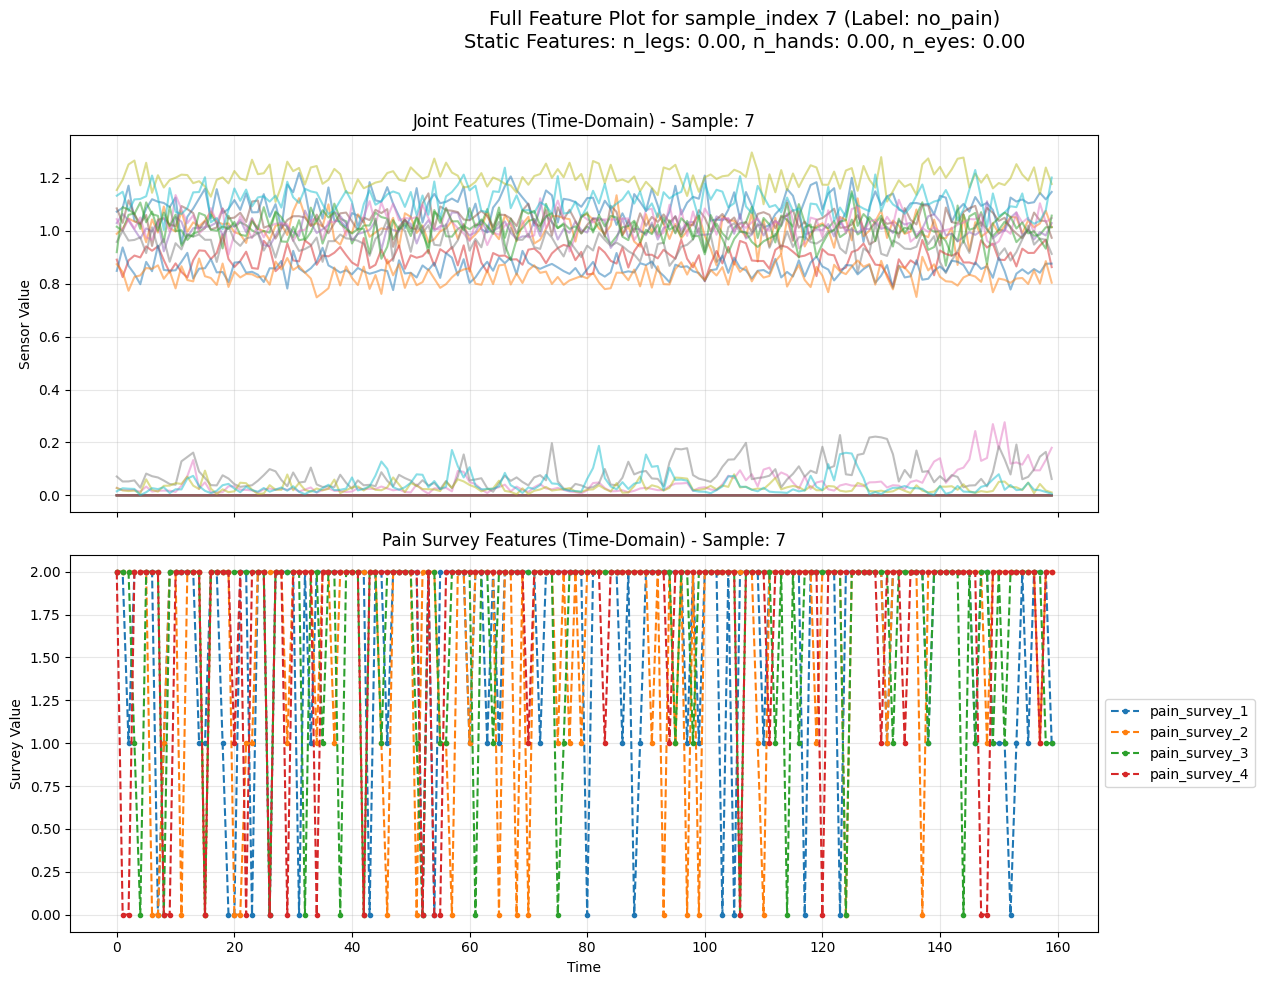

In [278]:

print("--- Plotting a single sample's features ---")

plot_sid = train_sids[0]
plot_label = df_labels[df_labels['sample_index'] == plot_sid]['label'].values[0]

print(f"Plotting sample_index: {plot_sid} (Label: {plot_label})")

# 2. Get the original data for this sample
sample_df = df_train[df_train['sample_index'] == plot_sid].sort_values('time')

# 3. Get Static Features (This will be your 3 'n_' features)
if plot_sid in df_static_indices.index:
    static_data_series = df_static_indices.loc[plot_sid]
    static_data_str = ", ".join([f"{k}: {v:.2f}" for k, v in static_data_series.items()])
else:
    static_data_str = "Static data not found."


# 4. Create the plot with 2 subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

for col in temporal_cols_rnn: 
    ax1.plot(sample_df['time'], sample_df[col], label=col, alpha=0.5)
ax1.set_title(f"Joint Features (Time-Domain) - Sample: {plot_sid}")
ax1.set_ylabel("Sensor Value")
ax1.grid(alpha=0.3)

# 6. Plot all pain_cols on the second subplot (Time-Domain)
for col in pain_cols:
    ax2.plot(sample_df['time'], sample_df[col], label=col, linestyle='--', marker='o', markersize=3)
ax2.set_title(f"Pain Survey Features (Time-Domain) - Sample: {plot_sid}")
ax2.set_xlabel("Time")
ax2.set_ylabel("Survey Value")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(alpha=0.3)

fig_title = (
    f"Full Feature Plot for sample_index {plot_sid} (Label: {plot_label})\n"
    f"Static Features: {static_data_str}"
)
plt.suptitle(fig_title, fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 0.95]) # Adjusted top margin for new title
plt.show()

### Cross Entropy weighting

label
no_pain      0.773071
low_pain     0.142209
high_pain    0.084720
Name: proportion, dtype: float64


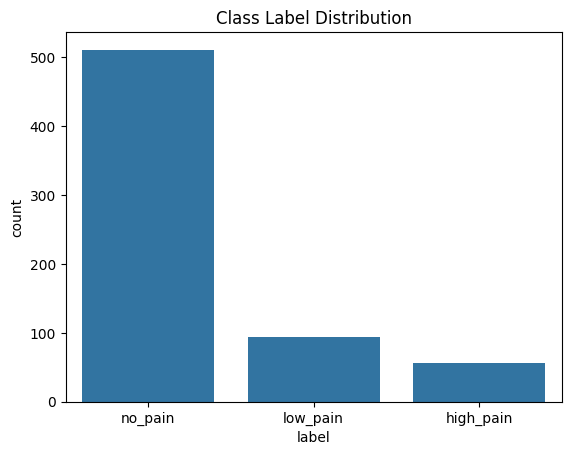


--- Calculating and Applying Class Weights ---
Label proportions:
 label
high_pain    0.084720
low_pain     0.142209
no_pain      0.773071
Name: proportion, dtype: float64
Calculated Weights:
 label
high_pain    0.096805
low_pain     0.057671
no_pain      0.010609
Name: proportion, dtype: float64
--- Label Smoothing is DISABLED ---


In [279]:
print(df_labels['label'].value_counts(normalize=True))

sns.countplot(x='label', data=df_labels)
plt.title('Class Label Distribution')
plt.show()

weights_tensor = None
smoothing_value = 0.0 

label_proportions = df_labels['label'].value_counts(normalize=True).sort_index()

if CROSS_ENTROPY_WEIGHTING:
    print("\n--- Calculating and Applying Class Weights ---")
    print("Label proportions:\n", label_proportions)
    
    # Calculate weights (1 / proportion)
    weights = 1.0 / label_proportions
    weights = weights / weights.sum() ** WEIGHT_CE_INTENSITY
    print("Calculated Weights:\n", weights)
    
    weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
else:
    print("\n--- Using Unweighted Cross Entropy Loss ---")

if LABEL_SMOOTHING_EPSILON > 0.0:
    smoothing_value = LABEL_SMOOTHING_EPSILON
    print(f"--- Applying Label Smoothing with Epsilon = {smoothing_value} ---")
else:
    print("--- Label Smoothing is DISABLED ---")

CRITERION = nn.CrossEntropyLoss(
    weight=weights_tensor,               
    label_smoothing=smoothing_value      
)

## Neural Network Model

#### Dual Classifier

In [280]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualClassifier(nn.Module):
    def __init__(
        self,
        # --- INPUT SIZES ---
        joint_input_size,   
        pain_input_size,    
        static_input_size,   
        
        # === Pain Embedding Hyperparameters ===
        pain_vocab_size,     
        pain_embedding_dim, 
        
        # === FIX: Static Embedding Hyperparameters ===
        static_vocab_size,  
        static_embedding_dim, 
        
        # --- HYPERPARAMETERS ---
        rnn_hidden_size,       
        num_layers,
        num_classes,
        rnn_type='LSTM',
        bidirectional=False,
        dropout_rate=0.2
    ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.rnn_hidden_size = rnn_hidden_size
        self.bidirectional = bidirectional

        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        rnn_module = rnn_map[rnn_type]

        # --- TEMPORAL BRANCH: ---
        
        # 1. Joint Features (Unchanged)
        self.joint_batch_norm = nn.BatchNorm1d(joint_input_size)

        # 2. Pain Features (Method 2: Shared Embedding)
        self.pain_embedding = nn.Embedding(
            num_embeddings=pain_vocab_size, 
            embedding_dim=pain_embedding_dim
        )
        total_embedded_pain_size = pain_input_size * pain_embedding_dim # e.g., 4 * 3 = 12

        # 3. RNN Input Calculation
        combined_rnn_input_size = joint_input_size + total_embedded_pain_size # e.g., 30 + 12 = 42

        rnn_dropout = dropout_rate if num_layers > 1 else 0
        self.rnn = rnn_module(
            input_size=combined_rnn_input_size,
            hidden_size=rnn_hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=rnn_dropout
        )
        rnn_output_size = rnn_hidden_size * (2 if bidirectional else 1)
        

        self.static_embedding = nn.Embedding(
            num_embeddings=static_vocab_size, 
            embedding_dim=static_embedding_dim
        )
        
        total_embedded_static_size = static_input_size * static_embedding_dim
        
        # Simple dropout for the concatenated static features
        self.static_dropout = nn.Dropout(dropout_rate)


        # --- ATTENTION (Unchanged) ---
        self.attention_score = nn.Linear(rnn_output_size, 1)

        # --- FUSION & CLASSIFICATION ---

        fused_input_size = total_embedded_static_size + rnn_output_size # e.g., 6 + rnn_output
        
        self.fusion_gate = nn.Linear(fused_input_size, fused_input_size)
        self.classifier = nn.Linear(fused_input_size, num_classes)


    def forward(self, x_joints, x_pain, x_static):
        # x_joints: [B, T, joint_input_size]
        # x_pain:   [B, T, pain_input_size] (long)
        # x_static: [B, static_input_size] (long)

        # --- STATIC BRANCH ---
        # Embed all static features using the single embedding layer
        # x_static: [B, static_input_size] -> [B, static_input_size, static_embedding_dim]
        static_embedded = self.static_embedding(x_static)
        # Flatten embedding: [B, static_input_size * static_embedding_dim]
        static_features = static_embedded.view(x_static.size(0), -1)
        static_features = self.static_dropout(static_features)

        # --- TEMPORAL BRANCH ---
        x_joints_norm = self.joint_batch_norm(x_joints.transpose(1, 2)).transpose(1, 2)
        
        # Embed pain input
        x_pain_emb = self.pain_embedding(x_pain)  # [B, T, pain_input_size, pain_embedding_dim]
        B, T, P, E = x_pain_emb.shape
        x_pain_emb = x_pain_emb.view(B, T, P * E)  # [B, T, pain_input_size * pain_embedding_dim]

        combined_stream = torch.cat([x_joints_norm, x_pain_emb], dim=2)
        rnn_out, _ = self.rnn(combined_stream)

        # Attention
        attn_scores = self.attention_score(rnn_out)  # [B, T, 1]
        attn_weights = F.softmax(attn_scores, dim=1)
        temporal_features = torch.sum(attn_weights * rnn_out, dim=1)  # [B, rnn_output_size]

        # --- FUSION & CLASSIFICATION ---
        combined_features = torch.cat([static_features, temporal_features], dim=1)
        gate = torch.sigmoid(self.fusion_gate(combined_features))
        gated_features = combined_features * gate
        logits = self.classifier(gated_features)

        return logits

### One Epoch Training

In [281]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0):

    model.train()
    running_criterion_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        x_joints, x_pain, x_static = inputs
        
        x_joints = x_joints.to(device)
        x_pain = x_pain.to(device)
        x_static = x_static.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x_joints, x_pain, x_static) 
            
            criterion_loss = criterion(logits, targets)
            
            if torch.isnan(criterion_loss):
                print(f"NaN loss at batch {batch_idx}")
                continue
            
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            total_loss = criterion_loss + l1_lambda * l1_norm
            
        scaler.scale(total_loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_criterion_loss += criterion_loss.item() * targets.size(0)
        
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_criterion_loss / len(train_loader.dataset)
    
    all_targets_np = np.concatenate(all_targets)
    all_predictions_np = np.concatenate(all_predictions)

    epoch_f1 = f1_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_precision = precision_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    
    return epoch_loss, epoch_f1, epoch_precision, epoch_recall


### One Epoch Validation

In [282]:

def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    
    all_predictions = [] 
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            x_joints, x_pain, x_static = inputs
            
            x_joints = x_joints.to(device)
            x_pain = x_pain.to(device)
            x_static = x_static.to(device)
            targets_device = targets.to(device) 

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x_joints, x_pain, x_static)
                loss = criterion(logits, targets_device)

            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            
            running_loss += loss.item() * targets.size(0)
            all_targets.append(targets.cpu().numpy()) 

    epoch_loss = running_loss / len(val_loader.dataset)
    
    all_targets_np = np.concatenate(all_targets)
    all_predictions_np = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_precision = precision_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    
    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

### Neural Network Fitting

In [283]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="",
        use_hybrid_functions=False): 

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': []     
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0
        
    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):

        train_loss, train_f1, train_precision, train_recall = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda
        )
    
        val_loss, val_f1, val_precision, val_recall = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # 3. Log history
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1) 
        # --- ADDED: Log new metrics ---
        training_history['train_precision'].append(train_precision)
        training_history['val_precision'].append(val_precision)
        training_history['train_recall'].append(train_recall)
        training_history['val_recall'].append(val_recall)
        # ------------------------------

        # 4. Print results
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f} (Per sample)")
        
        # 5. Early stopping 
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                
                save_path = "models/" + experiment_name + '_model.pt'
                save_dir = os.path.dirname(save_path)
                os.makedirs(save_dir, exist_ok=True) 
                
                torch.save(model.state_dict(), save_path) 
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # 6. Restore best weights
    best_model_path = "models/" + experiment_name + '_model.pt'
    if restore_best_weights and patience > 0:
        try:
            model.load_state_dict(torch.load(best_model_path))
            print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        except FileNotFoundError:
            print("No model checkpoint was saved (all scores were NaN or errors).")

    if patience == 0:
        save_dir = os.path.dirname(best_model_path)
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), best_model_path)

    if writer is not None:
        writer.close()

    return model, training_history

### Tools

In [284]:

def predict_and_log_full_dataset(model, data_loader, sample_indices_map, 
                                 output_folder, experiment_name, label_map, device, 
                                 use_hybrid_functions):
    """
    Runs prediction on the full dataset (data_loader) and logs per-sample results.
    """
    model.eval()
    all_probs = []
    window_sids = []
    
    # Map from numeric back to string labels
    inv_label_map = {v: k for k, v in label_map.items()}
    score_cols = [inv_label_map[i] for i in range(len(label_map))]
    
    # 1. Collect window-level probabilities
    with torch.no_grad():
        for i, inputs in enumerate(data_loader):
            
            # Since the data_loader is built on the final 100% data, 
            # inputs is a tuple: ((x_joints, x_pain, x_static), y_targets)
            x_joints, x_pain, x_static = inputs[0] # Get the 3 feature inputs
            
            # Move to device
            x_joints = x_joints.to(device)
            x_pain = x_pain.to(device)
            x_static = x_static.to(device)

            # Get model outputs
            outputs = model(x_joints, x_pain, x_static)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probabilities)
            
            # Since the loader is shuffled, we need to map the batch indices 
            # back to the original sample_indices from the dataset's underlying list
            batch_size = x_joints.size(0)
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            # Append the sample_indices for this batch
            if end_idx <= len(sample_indices_map):
                window_sids.extend(sample_indices_map[start_idx:end_idx])
            else:
                # Handle last batch if size is smaller
                window_sids.extend(sample_indices_map[start_idx:len(sample_indices_map)])


    all_probs = np.concatenate(all_probs)
    
    # 2. Create window-level analysis DF
    df_window_scores = pd.DataFrame(all_probs, columns=score_cols)
    df_window_scores['sample_index'] = window_sids

    # 3. Aggregate to get per-sample predictions (Mean Probability Vote)
    
    # Calculate the mean probability for each class across all windows
    mean_probs_per_sample = df_window_scores.groupby('sample_index')[score_cols].mean()
    
    # Determine the predicted label (argmax of the mean probabilities)
    final_pred_str = mean_probs_per_sample[score_cols].idxmax(axis=1)
    
    # Get the confidence of the predicted label
    final_confidence = mean_probs_per_sample.max(axis=1)

    # 4. Create the final log DataFrame
    df_log = pd.DataFrame({
        'sample_index': mean_probs_per_sample.index,
        'predicted_label': final_pred_str.values,
        'confidence': final_confidence.values
    })
    
    # 5. Save the log file
    base_dir = os.path.dirname(os.path.abspath(__file__))
    path = os.path.join(base_dir, "ensemble_training", output_folder)
    os.makedirs(path, exist_ok=True)
    log_filename = os.path.join(path, f"{experiment_name}.txt")
    
    # We save a TXT file with a tab separator
    df_log.to_csv(log_filename, sep='\t', index=False)
    print(f"   [LOGGED] Individual prediction and confidence saved to {log_filename}")
    
    return df_log

### Neural Network Summary

In [285]:
def plot_model_summary(
    model,
    rnn_input_shape,
    pain_input_shape,
    static_input_features
):
    """
    Prints a forward-flow summary showing branches (temporal vs static) with proper indentation.
    """
    output_shapes = {}
    hooks = []
    execution_order = []

    def get_hook(name):
        def hook(module, inputs, outputs):
            execution_order.append(name)
            # Handle outputs: tensor or tuple of tensors
            if isinstance(outputs, tuple):
                if isinstance(outputs[0], torch.Tensor):
                    shape = list(outputs[0].shape)
                    shape[0] = -1
                    output_shapes[name] = str(shape)
                else:
                    output_shapes[name] = "tuple"
            elif isinstance(outputs, torch.Tensor):
                shape = list(outputs.shape)
                shape[0] = -1
                output_shapes[name] = str(shape)
            else:
                output_shapes[name] = "unknown"
        return hook

    # --- Create dummy inputs ---
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")

    dummy_temporal = torch.randn(1, *rnn_input_shape).to(device)
    # Pain input: integer indices for embedding
    if any(isinstance(m, nn.Embedding) for n, m in model.named_modules() if 'pain' in n):
        dummy_pain = torch.randint(
            0, model.pain_embedding.num_embeddings, (1, *pain_input_shape), dtype=torch.long
        ).to(device)
    else:
        dummy_pain = torch.randn(1, *pain_input_shape).to(device)
    # Static input: integer indices for embedding
    if any(isinstance(m, nn.Embedding) for n, m in model.named_modules() if 'static' in n):
        dummy_static = torch.randint(
            0, model.static_embedding.num_embeddings, (1, static_input_features), dtype=torch.long
        ).to(device)
    else:
        dummy_static = torch.randn(1, static_input_features).to(device)

    # --- Register hooks ---
    for name, module in model.named_modules():
        if name:  # skip the top-level module
            hooks.append(module.register_forward_hook(get_hook(name)))

    # --- Forward pass ---
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_temporal, dummy_pain, dummy_static)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")

    # --- Remove hooks ---
    for h in hooks:
        h.remove()

    # --- Deduplicate execution order ---
    seen = set()
    ordered_layers = [x for x in execution_order if not (x in seen or seen.add(x))]

    # --- Parameter counts ---
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_nontrainable = total_params - total_trainable

    # --- Print summary ---
    print("-" * 100)
    print(f"{'Layer (execution order)':<60} {'Output Shape':<30} {'Param #':>10}")
    print("=" * 100)

    layer_col_width = 60
    output_col_width = 30

    for name in ordered_layers:
        module = dict(model.named_modules())[name]
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)

        # Determine branch indentation
        if "static" in name or "mlp" in name:
            branch_indent = 2
        elif "rnn" in name or "attention" in name:
            branch_indent = 1
        elif "fusion" in name or "classifier" in name:
            branch_indent = 3
        else:
            branch_indent = 0

        indent_str = "  " * branch_indent
        layer_name = f"{indent_str}{name.split('.')[-1]} ({type(module).__name__})"

        print(f"{layer_name:<{layer_col_width}}{output_shapes.get(name,'N/A'):<{output_col_width}}{params:>10,}")

    print("=" * 100)
    print(f"{'Total parameters:':<60} {total_params:>40,}")
    print(f"{'Trainable parameters:':<60} {total_trainable:>40,}")
    print(f"{'Non-trainable parameters:':<60} {total_nontrainable:>40,}")
    print("-" * 100)


## Cross Validation

### K-Fold Cross Validation

In [286]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from itertools import chain

def k_fold_cross_validation(
    df_train, df_labels, df_static_engineered,
    
    # --- GLOBAL STATS (Numerical Streams) ---
    global_temporal_min, global_temporal_max,
    # global_pain_min, global_pain_max are NOT needed for categorical pain
    
    rnn_cols, original_joint_cols, pain_cols, label_map, 

    window_size, stride,    
    epochs, criterion, device, k, 
    # Model params
    batch_size, hidden_layers, hidden_size, learning_rate, 
    dropout_rate, rnn_type, bidirectional, l1_lambda, l2_lambda, 
    
    # --- EMBEDDING PARAMETERS ---
    pain_vocab_size,       
    pain_embedding_dim, 

    static_vocab_size=2,
    static_embedding_dim=4,
    
    # --- HYBRID/STANDARD FLAGS ---
    use_hybrid_functions=False,
    static_hidden_size=8,
    
    # --- OBSOLETE PARAMS (Kept for compatibility with calls) ---
    pain_branch_type='MLP', pain_num_layers=1, pain_hidden_size=16, pain_bidirectional=False, 
    # -------------------------------------------------------------

    cross_entropy_weighting=CROSS_ENTROPY_WEIGHTING,
    weight_ce_intensity=WEIGHT_CE_INTENSITY,
    label_smoothing_epsilon=LABEL_SMOOTHING_EPSILON,
    # CV params
    cv_params=None,
    patience=0, evaluation_metric="val_f1", mode='max',
    restore_best_weights=True, writer=None, verbose=10, 
    experiment_name_prefix="cv"):

    def new_getitem(self, idx):
        x_temporal_sample = self.X_rnn[idx].clone() 
        y_sample = self.y[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_temporal_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_temporal_sample[:, :self.n_joint_cols] = x_temporal_sample[:, :self.n_joint_cols] + noise.to(x_temporal_sample.device)
            
        return x_temporal_sample, y_sample

    # Dictionaries for history (initialization logic is correct)
    fold_losses, fold_metrics, best_scores = {}, {}, {}
    fold_train_losses, fold_train_metrics = {}, {}
    fold_val_precision, fold_val_recall, fold_train_precision, fold_train_recall = {}, {}, {}, {}
    best_precision_scores, best_recall_scores = {}, {}
    
    num_classes = len(label_map)
    temporal_input_size = len(rnn_cols) 
    static_input_size = len(df_static_engineered.columns)
    pain_input_size = len(pain_cols) # Should be 1

    df_static_safe = df_static_engineered.fillna(2)

    # (K-Fold splitting logic is all correct)
    unique_samples = df_train['sample_index'].unique()
    if USE_SEED:
        np.random.seed(SEED)
    unique_samples_shuffled = np.random.permutation(unique_samples)

    fold_size = len(unique_samples) // k
    folds = [unique_samples_shuffled[i:i + fold_size] for i in range(0, len(unique_samples_shuffled), fold_size)]
    if len(unique_samples) % k != 0:
        remainder = len(unique_samples) % k
        if folds:
            if len(folds) > 1:
                folds[-2] = np.concatenate((folds[-2], folds[-1]))
                folds.pop(-1)
            elif len(folds) == 1 and k == 1:
                pass 
    
    for fold_idx in range(k):
        if verbose > 0:
            print(f"\n--- Fold {fold_idx+1}/{k} ---")

        # (Filtering logic is correct)
        val_sids_fold = folds[fold_idx]
        train_sids_fold = np.array(list(chain(*[folds[i] for i in range(k) if i != fold_idx])))
        df_train_fold = df_train[df_train['sample_index'].isin(train_sids_fold)]
        df_labels_train_fold = df_labels[df_labels['sample_index'].isin(train_sids_fold)]
        df_val_fold = df_train[df_train['sample_index'].isin(val_sids_fold)]
        df_labels_val_fold = df_labels[df_labels['sample_index'].isin(val_sids_fold)]

        # (build_fixed_sequences calls - Pain min/max are NOT needed here)
        (X_train_rnn, X_train_pain), y_train_fold, train_window_sids_fold = build_fixed_sequences(
            df_train_fold, df_labels_train_fold, rnn_cols, pain_cols, label_map, 
            temporal_min=global_temporal_min, temporal_max=global_temporal_max,  
            window=window_size, stride=stride
        )
        (X_val_rnn, X_val_pain), y_val_fold, val_window_sids_fold = build_fixed_sequences(
            df_val_fold, df_labels_val_fold, rnn_cols, pain_cols, label_map, 
            temporal_min=global_temporal_min, temporal_max=global_temporal_max,  
            window=window_size, stride=stride
        )

        # (Dynamic Loss Criterion logic is correct)
        if cross_entropy_weighting:
            fold_label_proportions = df_labels_train_fold['label'].value_counts(normalize=True).sort_index()
            weights = 1.0 / fold_label_proportions
            weights = weights / weights.sum() ** weight_ce_intensity
            weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
            if verbose > 0: print(f"  Dynamic Loss Weights (Intensity {weight_ce_intensity}): {weights.values}")
        else:
            weights_tensor = None
            if verbose > 0: print("  Dynamic Loss: Using unweighted criterion.")
        CRITERION_FOLD = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=label_smoothing_epsilon)
        if verbose > 0 and label_smoothing_epsilon > 0.0: print(f"  Dynamic Loss: Label Smoothing Epsilon: {label_smoothing_epsilon}")

        # (Dataset creation is correct)
        train_dataset = PainDataset(
            X_train_rnn, X_train_pain, y_train_fold, train_window_sids_fold, df_static_safe, 
            is_train=True, n_joint_cols=len(original_joint_cols), noise_level=NOISE_STD_DEV
        )
        val_dataset = PainDataset(
            X_val_rnn, X_val_pain, y_val_fold, val_window_sids_fold, df_static_safe, 
            is_train=False
        )
            

        model = DualClassifier(
            joint_input_size=temporal_input_size, 
            pain_input_size=pain_input_size,
            static_input_size=static_input_size, 
            
            # These are the new required embedding params
            pain_vocab_size=pain_vocab_size,
            pain_embedding_dim=pain_embedding_dim, 

            static_vocab_size=static_vocab_size,
            static_embedding_dim=static_embedding_dim,

            rnn_hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes, 
            rnn_type=rnn_type,
            bidirectional=bidirectional, 
            dropout_rate=dropout_rate
        ).to(device)
        # --------------------------------------------------

        rnn_shape = (window_size, temporal_input_size) 
        pain_shape = (window_size, pain_input_size)     
        static_features = static_input_size             
        
        plot_model_summary(
            model, 
            rnn_input_shape=rnn_shape,
            pain_input_shape=pain_shape,
            static_input_features=static_features
        )

        # (DataLoader creation is correct)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        if verbose > 0:
            print(f"  Training windows: {len(train_dataset)}")
            print(f"  Validation windows: {len(val_dataset)}")

        # (Optimizer and scaler are correct)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
        fold_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        verbose_cv = cv_params.get('verbose_cv_run', 0) if cv_params else 0

        # (fit call is correct)
        _, training_history = fit(
            model=model, train_loader=train_loader, val_loader=val_loader,
            epochs=epochs, criterion=CRITERION_FOLD, optimizer=optimizer,
            scaler=fold_scaler, device=device, writer=writer,
            patience=patience, verbose=verbose_cv, l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric, mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name_prefix}/fold_{fold_idx}",
            use_hybrid_functions=use_hybrid_functions 
        )

        # 11. Store results (logic is correct)
        fold_losses[f"fold_{fold_idx}"] = training_history['val_loss']
        fold_metrics[f"fold_{fold_idx}"] = training_history['val_f1']
        fold_train_losses[f"fold_{fold_idx}"] = training_history['train_loss']
        fold_train_metrics[f"fold_{fold_idx}"] = training_history['train_f1']

        # (Save new metric histories)
        fold_val_precision[f"fold_{fold_idx}"] = training_history.get('val_precision', [])
        fold_val_recall[f"fold_{fold_idx}"] = training_history.get('val_recall', [])
        fold_train_precision[f"fold_{fold_idx}"] = training_history.get('train_precision', [])
        fold_train_recall[f"fold_{fold_idx}"] = training_history.get('train_recall', [])
        
        # (Get best scores from best F1 epoch)
        if training_history['val_f1']:
            best_epoch_idx = np.argmax(training_history['val_f1'])
            best_scores[f"fold_{fold_idx}"] = training_history['val_f1'][best_epoch_idx]
            
            if 'val_precision' in training_history and len(training_history['val_precision']) > best_epoch_idx:
                best_precision_scores[f"fold_{fold_idx}"] = training_history['val_precision'][best_epoch_idx]
            else:
                best_precision_scores[f"fold_{fold_idx}"] = 0.0
                
            if 'val_recall' in training_history and len(training_history['val_recall']) > best_epoch_idx:
                best_recall_scores[f"fold_{fold_idx}"] = training_history['val_recall'][best_epoch_idx]
            else:
                best_recall_scores[f"fold_{fold_idx}"] = 0.0
        else:
            best_scores[f"fold_{fold_idx}"] = 0.0
            best_precision_scores[f"fold_{fold_idx}"] = 0.0
            best_recall_scores[f"fold_{fold_idx}"] = 0.0

    # Calculate mean/std for F1 (logic is correct)
    all_best_scores = [best_scores[k] for k in best_scores.keys() if k.startswith("fold_")]
    if all_best_scores:
        best_scores["mean"] = np.mean(all_best_scores)
        best_scores["std"] = np.std(all_best_scores)
    else:
        best_scores["mean"] = 0.0
        best_scores["std"] = 0.0

    # (Calculate mean/std for new metrics - logic is correct)
    all_best_precision_scores = [best_precision_scores[k] for k in best_precision_scores.keys() if k.startswith("fold_")]
    if all_best_precision_scores:
        best_precision_scores["mean"] = np.mean(all_best_precision_scores)
        best_precision_scores["std"] = np.std(all_best_precision_scores)
    else:
        best_precision_scores["mean"] = 0.0
        best_precision_scores["std"] = 0.0

    all_best_recall_scores = [best_recall_scores[k] for k in best_recall_scores.keys() if k.startswith("fold_")]
    if all_best_recall_scores:
        best_recall_scores["mean"] = np.mean(all_best_recall_scores)
        best_recall_scores["std"] = np.std(all_best_recall_scores)
    else:
        best_recall_scores["mean"] = 0.0
        best_recall_scores["std"] = 0.0

    if verbose > 0:
        print(f"\nCross-validation F1 score: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")
        print(f"Cross-validation Precision score: {best_precision_scores['mean']:.4f} ± {best_precision_scores['std']:.4f}")
        print(f"Cross-validation Recall score: {best_recall_scores['mean']:.4f} ± {best_recall_scores['std']:.4f}")

    # (Return all new dictionaries)
    return (
        fold_losses, fold_metrics, best_scores, 
        fold_train_losses, fold_train_metrics,
        fold_val_precision, fold_val_recall,
        fold_train_precision, fold_train_recall,
        best_precision_scores, best_recall_scores
    )

### K-Fold Training

In [ ]:
if CROSS_VALIDATION_TRAINING:
    cv_params_direct = {
        'epochs': EPOCHS,
        'k': K,
        'patience': PATIENCE,
        'verbose_cv_run': VERBOSE_CV_RUN,
    }

    print("Starting direct K-Fold Cross-Validation on the Hybrid Model...")

    # --- 2. Execute k_fold_cross_validation with Hybrid Parameters ---
    (
        fold_losses, fold_metrics, best_scores, 
        fold_train_losses, fold_train_metrics, 
        fold_val_precision, fold_val_recall, 
        fold_train_precision, fold_train_recall, 
        best_precision_scores, best_recall_scores
    ) = k_fold_cross_validation(
        
        df_train=df_train,
        df_labels=df_labels,
        df_static_engineered=df_static_indices, 
        
        global_temporal_min=GLOBAL_TEMPORAL_MIN,
        global_temporal_max=GLOBAL_TEMPORAL_MAX,


        rnn_cols=temporal_cols_rnn,
        original_joint_cols=original_joint_cols,
        pain_cols=pain_cols,
        
        label_map=label_map,
        window_size=WINDOW_SIZE, stride=STRIDE,    
        
        epochs=EPOCHS,
        criterion=CRITERION,
        device=device,
        k=K,

        batch_size=BATCH_SIZE,
        hidden_layers=HIDDEN_LAYERS,
        hidden_size=HIDDEN_SIZE,
        learning_rate=LEARNING_RATE,
        dropout_rate=DROPOUT_RATE,
        rnn_type=RNN_TYPE,
        bidirectional=BIDIRECTIONAL,
        l1_lambda=L1_LAMBDA,
        l2_lambda=L2_LAMBDA, 
        
        # Hybrid/Static Params
        use_hybrid_functions=USE_STATIC_FEATURES,
        static_hidden_size=STATIC_HIDDEN_SIZE,
        
        pain_vocab_size=3, 
        pain_embedding_dim=PAIN_EMBEDDING_DIM,

        static_vocab_size=2,
        static_embedding_dim=STATIC_EMBEDDING_DIM,
        
        # (These are ignored by your new model but are fine to pass)
        pain_branch_type=PAIN_BRANCH_TYPE,      
        pain_num_layers=PAIN_NUM_LAYERS,
        pain_hidden_size=PAIN_HIDDEN_SIZE,
        pain_bidirectional=PAIN_BRANCH_BIDIRECTIONAL,

        # CV Control Params
        cv_params=cv_params_direct,
        patience=PATIENCE,
        evaluation_metric="val_f1",
        mode='max',
        restore_best_weights=True,
        verbose=VERBOSE,
        experiment_name_prefix="direct_cv"
    )

    print("\nDirect K-Fold Cross-Validation Complete.")
    print(f"Mean Per-Sample F1 Score across {K} folds: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

Starting direct K-Fold Cross-Validation on the Hybrid Model...

--- Fold 1/5 ---
Building fixed sequences (for EMBEDDING) with window=40, stride=20...
Building fixed sequences (for EMBEDDING) with window=40, stride=20...
  Dynamic Loss Weights (Intensity 1.6): [0.09585014 0.06262209 0.01159668]
----------------------------------------------------------------------------------------------------
Layer (execution order)                                      Output Shape                      Param #
    static_embedding (Embedding)                            [-1, 3, 3]                             6
    static_dropout (Dropout)                                [-1, 9]                                0
joint_batch_norm (BatchNorm1d)                              [-1, 30, 40]                          60
pain_embedding (Embedding)                                  [-1, 40, 4, 3]                         9
  rnn (LSTM)                                                [-1, 40, 8]                        2

### Plot Cross Validation Results

In [ ]:


def plot_cv_stability(best_scores_dict, k_splits, fold_train_metrics_dict=None, figsize=(10, 7)):

    # 1. Extract Validation scores
    val_scores = [
        best_scores_dict[f'fold_{i}'] 
        for i in range(k_splits) 
        if f'fold_{i}' in best_scores_dict
    ]
    if not val_scores:
        print("Warning: No validation fold scores found. Cannot plot stability.")
        return
    df_val = pd.DataFrame({'F1 Score': val_scores, 'Metric': 'Validation'})
    
    # 2. Process Training scores (if provided)
    if fold_train_metrics_dict:
        train_scores = [
            history[-1] for i in range(k_splits) 
            if (history := fold_train_metrics_dict.get(f'fold_{i}'))
        ]
        df_train = pd.DataFrame({'F1 Score': train_scores, 'Metric': 'Training (Final)'})
        df_plot = pd.concat([df_val, df_train])
        x_axis = "Metric"
        title = f'CV Stability: Train vs. Val F1 Scores ({k_splits} Folds)'
    else:
        df_plot = df_val
        x_axis = None
        title = f'CV Stability: Validation F1 Score ({k_splits} Folds)'

    # 3. Create its own plot
    plt.figure(figsize=figsize)
    ax = plt.gca() # Get current axis
    
    sns.boxplot(
        x=x_axis, y='F1 Score', data=df_plot, 
        palette='pastel', width=0.5, boxprops=dict(alpha=0.8), ax=ax,
        hue=x_axis, legend=False 
    )
    
    # Stripplot (This is the new fix)
    sns.stripplot(
        x=x_axis, y='F1 Score', data=df_plot, 
        alpha=0.7, jitter=0.1, 
        label='Individual Folds', dodge=True, ax=ax,
        hue=x_axis, legend=False,
        palette='dark:black'  # <-- MODIFIED: Replaced color='black'
    )

    # 4. Add mean line for Validation
    val_mean = df_val['F1 Score'].mean()
    val_std = df_val['F1 Score'].std()
    
    if x_axis: # Side-by-side plot
        ax.axhline(val_mean, color='red', linestyle='--', linewidth=2, 
                   xmin=0.05, xmax=0.45, 
                   label=f'Mean Val F1: {val_mean:.4f} ± {val_std:.4f}')
    else: # Single plot
        ax.axhline(val_mean, color='red', linestyle='--', linewidth=2,
                   label=f'Mean Val F1: {val_mean:.4f} ± {val_std:.4f}')

    ax.set_title(title)
    ax.set_ylabel('Per-Sample F1 Score')
    ax.set_xlabel('Metric')
    ax.grid(alpha=0.3, axis='y')
    
    # Combine legends
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.tight_layout()
    plt.show()



def plot_cv_learning_curves(
    fold_val_metrics_dict, fold_train_metrics_dict,
    fold_val_losses_dict,fold_train_losses_dict,
    fold_val_precision_dict,fold_train_precision_dict,
    fold_val_recall_dict,fold_train_recall_dict,
    logtime, 
    figsize=(16, 12),
):
    """
    Creates a 2x2 subplot dashboard showing:
    [0,0] = Loss (Train vs. Val)
    [0,1] = F1 Score (Train vs. Val)
    [1,0] = Precision (Train vs. Val)
    [1,1] = Recall (Train vs. Val)
    
    All plots show the Mean ± Std Dev and the best F1 epoch.
    """
    
    def process_data(val_dict, train_dict, metric_name):
        df_val = pd.DataFrame.from_dict(val_dict, orient='index').transpose()
        df_val = df_val.melt(ignore_index=False, var_name='Fold', value_name=metric_name).reset_index().rename(columns={'index':'Epoch'})
        df_val = df_val.dropna()
        df_val['Metric'] = 'Validation'
        
        df_train = pd.DataFrame.from_dict(train_dict, orient='index').transpose()
        df_train = df_train.melt(ignore_index=False, var_name='Fold', value_name=metric_name).reset_index().rename(columns={'index':'Epoch'})
        df_train = df_train.dropna()
        df_train['Metric'] = 'Training'
        
        df_combined = pd.concat([df_val, df_train])
        df_combined['Epoch'] = df_combined['Epoch'] + 1 
        return df_combined, df_val # Return df_val separately for finding best epoch
    
    df_f1, df_val_f1 = process_data(fold_val_metrics_dict, fold_train_metrics_dict, 'F1 Score')
    df_loss, _ = process_data(fold_val_losses_dict, fold_train_losses_dict, 'Loss')
    df_precision, _ = process_data(fold_val_precision_dict, fold_train_precision_dict, 'Precision')
    df_recall, _ = process_data(fold_val_recall_dict, fold_train_recall_dict, 'Recall')

    mean_val_f1_by_epoch = df_val_f1.groupby('Epoch')['F1 Score'].mean()
    best_f1_epoch = mean_val_f1_by_epoch.idxmax()

    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    palette = {'Training': 'blue', 'Validation': 'orange'}
    
    # --- Subplot [0, 0]: Loss Curves ---
    sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Metric', palette=palette, ax=axes[0, 0])
    axes[0, 0].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[0, 0].set_title('Training vs. Validation Loss')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].legend()
    
    # --- Subplot [0, 1]: F1 Score Curves ---
    sns.lineplot(data=df_f1, x='Epoch', y='F1 Score', hue='Metric', palette=palette, ax=axes[0, 1])
    axes[0, 1].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[0, 1].set_title('Training vs. Validation F1 Score')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].legend()

    # --- Subplot [1, 0]: Precision Curves ---
    sns.lineplot(data=df_precision, x='Epoch', y='Precision', hue='Metric', palette=palette, ax=axes[1, 0])
    axes[1, 0].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[1, 0].set_title('Training vs. Validation Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].legend()

    # --- Subplot [1, 1]: Recall Curves ---
    sns.lineplot(data=df_recall, x='Epoch', y='Recall', hue='Metric', palette=palette, ax=axes[1, 1])
    axes[1, 1].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[1, 1].set_title('Training vs. Validation Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].legend()

    fig.suptitle('K-Fold Learning Curve Analysis (Mean ± Std Dev)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 


    folder_name = "cross_validation_log"
    os.makedirs(folder_name, exist_ok=True)
    
    file_name = f"experiment_{logtime}.png"
    file_path = os.path.join(folder_name, file_name)
    
    fig.savefig(file_path, dpi=150, bbox_inches='tight') 
    print(f"Successfully saved learning curve plot to {file_path}")

    
    plt.show()



if CROSS_VALIDATION_TRAINING:

    log_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    
    print("Plotting CV Stability (Training vs. Validation)...")
    plot_cv_stability(
        best_scores, 
        k_splits=K, 
        fold_train_metrics_dict=fold_train_metrics 
    )
    
    print("Plotting CV Learning Curves (Mean ± Std Dev)...")
    plot_cv_learning_curves(
        fold_val_metrics_dict=fold_metrics,
        fold_train_metrics_dict=fold_train_metrics,
        fold_val_losses_dict=fold_losses,
        fold_train_losses_dict=fold_train_losses,
        fold_val_precision_dict=fold_val_precision,
        fold_train_precision_dict=fold_train_precision,
        fold_val_recall_dict=fold_val_recall,
        fold_train_recall_dict=fold_train_recall,
        logtime=log_time
    )




### Save results

In [ ]:

if  CROSS_VALIDATION_TRAINING:
    print("Training complete. Logging results...")
    
    experiment_name_prefix = "direct_cv"  

    folder_name = "cross_validation_log"
    os.makedirs(folder_name, exist_ok=True)
    
    file_name = f"cross_validation_history.txt"
    file_path = os.path.join(folder_name, file_name)

    
    # Get F1 stats
    mean_f1 = best_scores.get('mean', 0.0)
    std_f1 = best_scores.get('std', 0.0)
    fold_scores = [
        best_scores[k] 
        for k in best_scores 
        if k.startswith('fold_')
    ]

    # --- ADDED: Get Precision and Recall stats ---
    mean_precision = best_precision_scores.get('mean', 0.0)
    std_precision = best_precision_scores.get('std', 0.0)
    fold_precision_scores = [
        best_precision_scores[k] 
        for k in best_precision_scores
        if k.startswith('fold_')
    ]
    
    mean_recall = best_recall_scores.get('mean', 0.0)
    std_recall = best_recall_scores.get('std', 0.0)
    fold_recall_scores = [
        best_recall_scores[k] 
        for k in best_recall_scores 
        if k.startswith('fold_')
    ]
    # ---------------------------------------------

    try:
        with open(file_path, "a") as f:
            
            f.write(f"--- Log Entry: {log_time} ---\n")
            f.write(f"Experiment Name: {experiment_name_prefix} (K={K})\n")
            f.write("\n")
            
            # --- FIXED PARAMETERS ---
            f.write("Fixed Parameters:\n")
            f.write(f"  - SEED_FLAG: {USE_SEED}\n")
            f.write(f"  - SEED: {SEED}\n")
            f.write(f"  - EPOCHS: {EPOCHS}\n")
            f.write(f"  - PATIENCE: {PATIENCE}\n")
            f.write(f"  - CROSS_ENTROPY_FLAG: {CROSS_ENTROPY_WEIGHTING}\n")
            f.write(f"  - CROSS_ENTROPY_W_INTENSITY: {WEIGHT_CE_INTENSITY}\n")
            f.write(f"  - LABEL_SMOOTHING: {LABEL_SMOOTHING_EPSILON}\n")
            f.write("\n")
            
            # --- HYPERPARAMETERS ---
            f.write("Hyperparameters:\n")
            f.write("\n")

            f.write("  --- General Optimization ---\n")
            f.write(f"  - LEARNING_RATE: {LEARNING_RATE}\n")
            f.write(f"  - BATCH_SIZE: {BATCH_SIZE}\n")
            f.write(f"  - WINDOW_SIZE: {WINDOW_SIZE}\n")
            f.write(f"  - STRIDE: {STRIDE}\n")
            
            f.write("  --- General Regularization ---\n")
            f.write(f"  - DROPOUT_RATE: {DROPOUT_RATE}\n")
            f.write(f"  - L2_LAMBDA (Weight Decay): {L2_LAMBDA}\n")
            f.write(f"  - L1_LAMBDA: {L1_LAMBDA}\n")
            f.write(f"  - NOISE_STD_DEV (on Joints): {NOISE_STD_DEV}\n")
            f.write("\n")

            # --- Architecture Log (This is correct) ---
            f.write("  --- Hybrid Architecture (2-Branch: DualClassifier) ---\n")
            f.write("  - Branch 1 (Static MLP):\n")
            f.write(f"      - RNN_TYPE: {RNN_TYPE}\n")
            f.write(f"      - RNN_HIDDEN_LAYERS: {HIDDEN_LAYERS}\n")
            f.write(f"      - RNN_HIDDEN_SIZE: {HIDDEN_SIZE}\n")
            f.write(f"      - RNN_BIDIRECTIONAL: {BIDIRECTIONAL}\n")
            f.write("  - Branch 2 (Combined RNN):\n")
            f.write(f"      - PAIN_EMBEDDING_DIM: {PAIN_EMBEDDING_DIM}\n")
            f.write(f"      - STATIC_HIDDEN_SIZE: {STATIC_HIDDEN_SIZE}\n")
            f.write(f"      - STATIC_EMBEDDING_DIM {STATIC_EMBEDDING_DIM}\n") 
            f.write("\n")
            
            # --- ADDED: Log all CV results ---
            f.write(f"Cross-Validation Results ({K} Folds):\n")
            f.write(f"  - Mean Validation F1 Score: {mean_f1:.4f} (Std Dev: {std_f1:.4f})\n")
            f.write(f"  - Mean Validation Precision: {mean_precision:.4f} (Std Dev: {std_precision:.4f})\n")
            f.write(f"  - Mean Validation Recall: {mean_recall:.4f} (Std Dev: {std_recall:.4f})\n")
            f.write("\n")
            
            f.write("  - Individual Fold F1 Scores:\n")
            for i, score in enumerate(fold_scores):
                f.write(f"    - Fold {i+1}: {score:.4f}\n")
                
            f.write("  - Individual Fold Precision Scores:\n")
            for i, score in enumerate(fold_precision_scores):
                f.write(f"    - Fold {i+1}: {score:.4f}\n")
                
            f.write("  - Individual Fold Recall Scores:\n")
            for i, score in enumerate(fold_recall_scores):
                f.write(f"    - Fold {i+1}: {score:.4f}\n")
            
            f.write("--------------------------------------\n\n")
        
        print("Successfully wrote CV results to cross_validation_history.txt")

    except Exception as e:
        print(f"Error writing to cross_validation_history.txt: {e}")

    sys.exit(0)

## Bayesian Search

In [ ]:
########################################################################
#   DO NOT EDIT BASE_VALUES BELOW UNLESS NEW PARAMETERS ARE ADDED
########################################################################
BASE_VALUES = {
    # General Optimization (Updated)
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,

    # Loss Parameters (NEW/UPDATED)
    'cross_entropy_weighting': CROSS_ENTROPY_WEIGHTING, # Fixed Flag
    'weight_ce_intensity': WEIGHT_CE_INTENSITY,         
    'label_smoothing_epsilon': LABEL_SMOOTHING_EPSILON, 

    
    # Branch 1 (Joints RNN) - Updated
    'rnn_type': RNN_TYPE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'bidirectional': BIDIRECTIONAL,
    
    # Branch 2 (Pain Survey Branch) - NEW
    'pain_branch_type': PAIN_BRANCH_TYPE,
    'pain_num_layers': PAIN_NUM_LAYERS,
    'pain_hidden_size': PAIN_HIDDEN_SIZE,
    'pain_branch_bidirectional': PAIN_BRANCH_BIDIRECTIONAL,

    # Branch 3 (Static MLP) - Updated
    'static_hidden_size': STATIC_HIDDEN_SIZE,
    
    # General Regularization (Updated)
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'noise_std_dev': NOISE_STD_DEV, 
}

# --- TUNABLE PARAMETERS ---
param_grid = {
    # Optimization
    'learning_rate': GS_LEARNING_RATES,
    'batch_size': GS_BATCH_SIZE, 
    'window_size': GS_WINDOW_SIZES, 
    'stride': GS_STRIDES,

    'weight_ce_intensity': GS_CE_INTENSITY,
    'label_smoothing_epsilon': GS_LABEL_SMOOTHING,
    
    # Branch 1 (Joints RNN)
    'hidden_layers': GS_HIDDEN_LAYERS,
    'hidden_size': GS_HIDDEN_SIZES,
    'rnn_type': GS_RNN_TYPES,
    'bidirectional': GS_BIDIRECTIONAL,
    
    # Branch 2 (Pain Survey Branch)
    'pain_branch_type': GS_PAIN_BRANCH_TYPES,
    'pain_num_layers': GS_PAIN_NUM_LAYERS,
    'pain_hidden_size': GS_PAIN_HIDDEN_SIZES,
    'pain_branch_bidirectional': GS_PAIN_BIDIRECTIONAL,

    # Branch 3 (Static MLP)
    'static_hidden_size': GS_STATIC_HIDDEN_SIZES,
    
    # Regularization
    'dropout_rate': GS_DROPOUT_RATES,
    'l1_lambda': GS_L1_LAMBDA, 
    'l2_lambda': GS_L2_LAMBDA,
    'noise_std_dev': GS_NOISE_STD_DEV,
}


# --- FIXED PARAMETERS ---
fixed_params = {
    k: v 
    for k, v in BASE_VALUES.items() 
    if k not in param_grid
}


### Bayesian Search hyperparameter tuning

In [ ]:
if BAYESIAN_SEARCH:
    print("\n--- Starting Bayesian Hyperparameter Optimization ---")
    print("To check dashboard, run: 'optuna-dashboard sqlite:///pirate_study.db'\n")
    print("\n\n*** THIS IS THE CORRECT SCRIPT RUNNING AT 11:38 PM ***\n\n")

    def objective(trial):
        
        tuned_config = {
            'batch_size': trial.suggest_categorical('batch_size', BS_BATCH_SIZE),
            'learning_rate': trial.suggest_float('learning_rate', BS_LEARNING_RATE[0], BS_LEARNING_RATE[1], log=True),
            'weight_ce_intensity': trial.suggest_float('weight_ce_intensity', BS_WEIGHT_CE_INTENSITY[0], BS_WEIGHT_CE_INTENSITY[1]),
            'label_smoothing_epsilon': trial.suggest_float('label_smoothing_epsilon', BS_LABEL_SMOOTHING[0], BS_LABEL_SMOOTHING[1]),
            'dropout_rate': trial.suggest_float('dropout_rate', BS_DROPOUT_RATE[0], BS_DROPOUT_RATE[1]),
            'l2_lambda': trial.suggest_float('l2_lambda', BS_L2_LAMBDA[0], BS_L2_LAMBDA[1], log=True),
            'noise_std_dev': trial.suggest_float('noise_std_dev', BS_NOISE_STD_DEV[0], BS_NOISE_STD_DEV[1]),

            'window_size': trial.suggest_categorical('window_size', BS_WINDOW_SIZE), 
            'stride': trial.suggest_categorical('stride', BS_STRIDE), 
            
            'hidden_layers': trial.suggest_categorical('hidden_layers', BS_HIDDEN_LAYERS),
            'hidden_size': trial.suggest_categorical('hidden_size', BS_HIDDEN_SIZE),
            'rnn_type': trial.suggest_categorical('rnn_type', BS_RNN_TYPE),
            'bidirectional': trial.suggest_categorical('bidirectional', BS_BIDIRECTIONAL),
            
            'pain_branch_type': trial.suggest_categorical('pain_branch_type', BS_PAIN_BRANCH_TYPE),
            'pain_num_layers': trial.suggest_categorical('pain_num_layers', BS_PAIN_NUM_LAYERS),
            'pain_hidden_size': trial.suggest_categorical('pain_hidden_size', BS_PAIN_HIDDEN_SIZE),
            'pain_branch_bidirectional': trial.suggest_categorical('pain_branch_bidirectional', BS_PAIN_BRANCH_BIDIRECTIONAL),

            'static_hidden_size': trial.suggest_categorical('static_hidden_size', BS_STATIC_HIDDEN_SIZE),
        }

        print(f"\n--- Starting Trial {trial.number} ---")
        for key, value in tuned_config.items():
            print(f"  > {key}: {value}")


        fixed_params_bayesian = {
            'batch_size': BATCH_SIZE,
            'cross_entropy_weighting': CROSS_ENTROPY_WEIGHTING,
            'l1_lambda': L1_LAMBDA,
        }
        
        run_params = {**fixed_params_bayesian, **tuned_config}
        
        run_params['window_size'] = int(run_params['window_size'])
        run_params['stride'] = int(run_params['stride'])
        
        config_desc = "_".join([f"{k}_{v}" for k, v in run_params.items()])
        config_hash = hashlib.sha256(config_desc.encode()).hexdigest()[:10]

        trial.set_user_attr("config_desc", config_desc)
        
        
        cv_params_for_trial = {
            'epochs': EPOCHS,
            'k': K,
            'patience': PATIENCE,
            'verbose_cv_run': VERBOSE_CV_RUN,
            'criterion': CRITERION, 
        }

        try:
            _, _, fold_scores = k_fold_cross_validation(
                df_train=df_train,
                df_labels=df_labels,
                df_static_engineered=df_static_engineered, 
                global_joint_min=GLOBAL_JOINT_MIN,
                global_joint_max=GLOBAL_JOINT_MAX,
                global_pain_min=GLOBAL_PAIN_MIN, 
                global_pain_max=GLOBAL_PAIN_MAX, 
                feature_cols=joint_cols + pain_cols,    
                joint_cols=joint_cols,          
                pain_cols=pain_cols,          
                label_map=label_map,

                window_size=run_params['window_size'],
                stride=run_params['stride'],            
                
                epochs=cv_params_for_trial['epochs'],
                criterion=cv_params_for_trial['criterion'], 
                device=device, 
                k=cv_params_for_trial['k'],
                patience=cv_params_for_trial['patience'],
                verbose=GRID_SEARCH_VERBOSE, 
                experiment_name_prefix=config_hash,
                cv_params=cv_params_for_trial,
                
                batch_size=run_params['batch_size'],
                hidden_layers=run_params['hidden_layers'],
                hidden_size=run_params['hidden_size'],
                learning_rate=run_params['learning_rate'],
                dropout_rate=run_params['dropout_rate'],
                rnn_type=run_params['rnn_type'],
                bidirectional=run_params['bidirectional'],
                l1_lambda=run_params['l1_lambda'],
                l2_lambda=run_params['l2_lambda'],
                
                use_hybrid_functions=USE_STATIC_FEATURES, 
                static_hidden_size=run_params['static_hidden_size'], 

                pain_branch_type=run_params['pain_branch_type'],
                pain_num_layers=run_params['pain_num_layers'],
                pain_hidden_size=run_params['pain_hidden_size'],
                pain_bidirectional=run_params['pain_branch_bidirectional'],
                
                cross_entropy_weighting=run_params['cross_entropy_weighting'],
                weight_ce_intensity=run_params['weight_ce_intensity'],
                label_smoothing_epsilon=run_params['label_smoothing_epsilon'],
            )
        
            mean_f1 = fold_scores["mean"]
            trial.set_user_attr("mean_f1", mean_f1)

            print(f"  > Trial {trial.number} Result: Mean F1 = {mean_f1:.4f}")
            
            return -mean_f1
        
        except Exception as e:
            print(f"--- ERROR in Trial {trial.number} ---")
            print(f"Configuration: {run_params}")
            print(f"Error: {e}")
            print(f"  > Trial {trial.number} Result: F1 = 0.0 (due to error)")
            # Prune the trial by returning a very high loss (e.g., 0 F1 score)
            return 0.0 
    
    start_time = datetime.now()
    
    STORAGE_URL = "sqlite:///pirate_study.db" 
    STUDY_NAME = "bayesian_search" 

    try:
        
        study = optuna.create_study(
            study_name=STUDY_NAME,
            storage=STORAGE_URL,
            direction="minimize",
            load_if_exists=True  
        )    
        
        print(f"--- Attempting to optimize study: '{STUDY_NAME}' ---")
        
        study.optimize(
            objective, 
            n_trials=BS_N_TRIALS, 
            show_progress_bar=True
        )
    
    except ValueError as e:
        if "Cannot set different distribution kind" in str(e):
            print(f"\n--- WARNING: Hyperparameter space has changed! ---")
            
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            NEW_STUDY_NAME = f"{STUDY_NAME}_{timestamp}"
            
            print(f"Old study '{STUDY_NAME}' is incompatible.")
            print(f"Starting a new study: '{NEW_STUDY_NAME}'\n")
            
            study = optuna.create_study(
                study_name=NEW_STUDY_NAME,
                storage=STORAGE_URL,
                direction="minimize",
                load_if_exists=False  
            )
            
            study.optimize(
                objective, 
                n_trials=BS_N_TRIALS, 
                show_progress_bar=True
            )
        else:
            print(f"--- An unexpected ValueError occurred ---")
            raise e
    
    end_time = datetime.now()
    total_time = end_time - start_time
    
    best_trial = study.best_trial
    best_score = -best_trial.value 
    best_config = best_trial.params
    
    print("\n--- Bayesian Optimization Complete ---")
    print(f"Best Score (Mean F1): {best_score:.4f}")
    print(f"Best Config:\n{best_config}")
    print(f"Total Runtime: {total_time}")

    with open("bayesian_search_results.txt", "a") as f:
        f.write(f"\n\n--- Bayesian Search Results Log ---\n")
        f.write(f"Timestamp: {start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Runtime: {total_time}\n")
        f.write(f"Total Trials: {len(study.trials)}\n")
        f.write(f"Best Validation F1 Score: {best_score:.4f}\n")
        f.write("Optimal Parameters:\n")
        for k, v in best_config.items():
            f.write(f"  {k:<25}: {v}\n")
        f.write("----------------------------------\n")

else:
    print("BAYESIAN_SEARCH is False. Skipping Bayesian Search CV.")

BAYESIAN_SEARCH is False. Skipping Bayesian Search CV.


## Full Dataset Training

### Single training

In [ ]:
if FULL_DATASET_TRAINING:
    print("\n--- FINAL TRAINING ON FULL DATASET ---")

    # The FINAL_EXPERIMENT_NAME is used to save and load the final model
    FINAL_EXPERIMENT_NAME = f"final_model_{OPTIMAL_EPOCHS}_epochs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    print(f"Starting final training on ALL data for {OPTIMAL_EPOCHS} epochs.")
    print(f"Final model will be saved as: {FINAL_EXPERIMENT_NAME}")

    # Set fixed training parameters
    EPOCHS_FINAL = OPTIMAL_EPOCHS
    PATIENCE_FINAL = 0 


    df_train_final = df_train 
    df_labels_final = df_labels 

    # Re-create all windows using 100% of the data (Val set is empty)
    (X_train_joints_final, X_train_pain_final), y_train_final, train_window_sids_final = build_fixed_sequences(
        df_train_final, df_labels_final, 
        temporal_cols_rnn, pain_cols, label_map,
        temporal_min=GLOBAL_TEMPORAL_MIN,  
        temporal_max=GLOBAL_TEMPORAL_MAX, 
        window=WINDOW_SIZE,
        stride=STRIDE
    )



    print(f"\nTotal windows created for FINAL training: {len(y_train_final)}")

    # --- STEP 3: RE-INITIALIZE DATASET AND LOADER (100%) ---

    # Create the final training dataset using the 100% windowed data
    train_dataset_final = PainDataset(
        X_train_joints_final, X_train_pain_final, y_train_final, train_window_sids_final, 
        df_static_indices, # <-- FIX: Use the INTEGER index dataframe
        is_train=True,  
        n_joint_cols=len(original_joint_cols), # FIX: Use correct variable name
        noise_level=NOISE_STD_DEV
    )
    train_loader_final = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=True)
    
    # We still need a val_loader for the fit function, even if it's the same
    val_loader_final = train_loader_final 

    model = DualClassifier(
        joint_input_size=len(temporal_cols_rnn), 
        pain_input_size=len(pain_cols),
        static_input_size=len(static_cols_raw), 
        
        # These are the new required embedding params
        pain_vocab_size=3,
        pain_embedding_dim=PAIN_EMBEDDING_DIM, 

        static_vocab_size=2,
        static_embedding_dim=STATIC_EMBEDDING_DIM,

        rnn_hidden_size=HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        num_classes=3, 
        rnn_type=RNN_TYPE,
        bidirectional=BIDIRECTIONAL, 
        dropout_rate=DROPOUT_RATE
    ).to(device)


    optimizer_final = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 
    scaler_final = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    rnn_model_final, final_training_history = fit(
        model=model,
        train_loader=train_loader_final, # 100% data
        val_loader=val_loader_final,   # Passed again to satisfy fit function
        epochs=EPOCHS_FINAL,
        criterion=CRITERION,
        optimizer=optimizer_final,
        scaler=scaler_final,
        device=device,
        verbose=VERBOSE,
        experiment_name=FINAL_EXPERIMENT_NAME,
        patience=PATIENCE_FINAL,
        l1_lambda=L1_LAMBDA,
        evaluation_metric="val_f1",
        use_hybrid_functions=USE_STATIC_FEATURES
    )

    rnn_model = model
    experiment_name = FINAL_EXPERIMENT_NAME 

    print("Final training complete. Model is ready for test prediction.")


--- FINAL TRAINING ON FULL DATASET ---
Starting final training on ALL data for 182 epochs.
Final model will be saved as: final_model_182_epochs_20251111_222337
Building fixed sequences (for EMBEDDING) with window=40, stride=20...

Total windows created for FINAL training: 4627
Training 182 epochs...
Epoch   1/182 | Train: Loss=0.6742, F1=0.6734, Prec=0.5976, Rec=0.7713 | Val: Loss=0.4118, F1=0.6741, Prec=0.5976, Rec=0.7731 (Per sample)
Epoch   2/182 | Train: Loss=0.3676, F1=0.6752, Prec=0.7401, Rec=0.7735 | Val: Loss=0.3044, F1=0.6741, Prec=0.5976, Rec=0.7731 (Per sample)
Epoch   3/182 | Train: Loss=0.2932, F1=0.7334, Prec=0.7241, Rec=0.8005 | Val: Loss=0.2629, F1=0.7967, Prec=0.7623, Rec=0.8407 (Per sample)
Epoch   4/182 | Train: Loss=0.2553, F1=0.7977, Prec=0.7633, Rec=0.8418 | Val: Loss=0.2174, F1=0.7999, Prec=0.7646, Rec=0.8433 (Per sample)
Epoch   5/182 | Train: Loss=0.2055, F1=0.8007, Prec=0.7653, Rec=0.8437 | Val: Loss=0.1821, F1=0.8010, Prec=0.7660, Rec=0.8450 (Per sample)
Epo

## Test Prediction

### Test set prediction

In [ ]:

# =============================================================================
# --- 1. CLASS DEFINITIONS ---
# =============================================================================

class TestWindowDataset(Dataset):
    """
    FIX: Updated to accept X_pain and X_static as torch.long (integer indices).
    """
    def __init__(self, X_joints, X_pain, X_static, window_sample_indices, static_map):
        self.X_joints = torch.tensor(X_joints, dtype=torch.float32)
        self.X_pain = torch.tensor(X_pain, dtype=torch.long)
        self.X_static_all = torch.tensor(X_static, dtype=torch.long)
        self.window_sample_indices = window_sample_indices
        self.static_map = static_map

    def __getitem__(self, index):
        x_joints_sample = self.X_joints[index]
        x_pain_sample = self.X_pain[index]
        sample_index = self.window_sample_indices[index]
        static_idx = self.static_map.get(sample_index)
        
        if static_idx is None:
            # Must return torch.long zeros
            x_static_sample = torch.zeros(self.X_static_all.shape[1], dtype=torch.long)
        else:
            x_static_sample = self.X_static_all[static_idx]
            
        return (x_joints_sample, x_pain_sample, x_static_sample)
    
    def __len__(self):
        return self.X_joints.shape[0]
        


print("\n--- Starting Test Set Prediction ---")
df_test = pd.read_csv('pirate_pain_test.csv')

float_cols = df_test.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_test[col] = df_test[col].astype(np.float32)
inv_label_map = {v: k for k, v in label_map.items()}


# --- 1. Define Feature Columns (matching the training script) ---
all_original_joint_cols_test = [c for c in df_test.columns if c.startswith('joint_')]
test_joint_cols = all_original_joint_cols_test[:-1]
n_joint_cols_test = len(test_joint_cols) 

test_pain_cols = [c for c in df_test.columns if c.startswith('pain_survey_')]
n_pain_cols_test = len(test_pain_cols)

print(f"Test set: Using {n_joint_cols_test} joint features and {n_pain_cols_test} pain features.")

# --- 2. Create Static Test Features ---
if USE_STATIC_FEATURES:
    print("Engineering test set static features (Categorical Indices)...")
    static_cols_raw_test = [c for c in df_test.columns if c.startswith('n_')]
    df_static_test_raw = df_test.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw_test]
    
    # Use the 0-indexed engineer_static_features function
    df_static_test_engineered = engineer_static_features(df_static_test_raw)
    
    # Use the features list from training (stats_dict) and ensure column order
    for col in stats_dict['static_features_list']:
        if col not in df_static_test_engineered:
            print(f"Warning: Test set missing static col '{col}'. Filling with 1 (index for '2').")
            df_static_test_engineered[col] = 1 # Use a valid index (1) as fallback
                
    df_static_test_engineered = df_static_test_engineered[stats_dict['static_features_list']]
    df_static_test_engineered = df_static_test_engineered.fillna(1) # Fill NaNs with a valid index

    # Prepare the integer data for the Dataset class
    static_map_test = {sid: i for i, sid in enumerate(df_static_test_engineered.index)} 
    static_data_test = df_static_test_engineered.values.astype(np.int64) # <-- Use integer data

# --- 3. Window the Test Data  ---

# Check for shape mismatch
if len(GLOBAL_TEMPORAL_MIN) != n_joint_cols_test:
    print(f"FATAL ERROR: Shape mismatch. Training normalization stats have {len(GLOBAL_TEMPORAL_MIN)} features, but test set is using {n_joint_cols_test}.")

# Use the correct GLOBAL names for Joint/Temporal features
global_min_tensor = torch.FloatTensor(GLOBAL_TEMPORAL_MIN)
global_max_tensor = torch.FloatTensor(GLOBAL_TEMPORAL_MAX)
global_range_tensor = global_max_tensor - global_min_tensor
global_range_tensor[global_range_tensor == 0] = 1
# ------------------------------------------------

test_windows_joints = []
test_windows_pain = []
test_window_indices = []

for sid in df_test['sample_index'].unique():
    seq_df = df_test[df_test['sample_index'] == sid]
    if len(seq_df) == 0:
        print(f"Warning: No features for test sample {sid}. Skipping.")
        continue
    
    # --- Get two separate feature sequences ---
    seq_joints = seq_df.sort_values('time')[test_joint_cols].values
    seq_pain = seq_df.sort_values('time')[test_pain_cols].values.astype(np.int64)
        
    # --- Normalize joint data (Still continuous) ---
    seq_tensor_joints = torch.FloatTensor(seq_joints)
    normalized_joints = 2 * ((seq_tensor_joints - global_min_tensor) / global_range_tensor) - 1
    seq_joints_normalized = normalized_joints.numpy()

    # Pain is already the correct integer indices
    seq_pain_normalized = seq_pain 
    
    # --- Padding ---
    padding_len = WINDOW_SIZE - len(seq_joints_normalized) % WINDOW_SIZE
    if padding_len < WINDOW_SIZE:
        padding_joint = np.zeros((padding_len, n_joint_cols_test), dtype='float32')
        # --- FIX: Pain padding must be ZEROS (index 0) and INT64 ---
        padding_pain = np.zeros((padding_len, n_pain_cols_test), dtype='int64') 
        
        seq_joints_padded = np.concatenate((seq_joints_normalized, padding_joint))
        seq_pain_padded = np.concatenate((seq_pain_normalized, padding_pain))
    else:
        seq_joints_padded = seq_joints_normalized
        seq_pain_padded = seq_pain_normalized
        
    idx = 0
    while idx + WINDOW_SIZE <= len(seq_joints_padded):
        test_windows_joints.append(seq_joints_padded[idx:idx + WINDOW_SIZE])
        test_windows_pain.append(seq_pain_padded[idx:idx + WINDOW_SIZE])
        test_window_indices.append(sid)
        idx += STRIDE

X_test_windows_joints = np.array(test_windows_joints)
X_test_windows_pain = np.array(test_windows_pain)
print(f"Created {len(X_test_windows_joints)} test windows from {df_test['sample_index'].nunique()} samples.")


test_dataset = TestWindowDataset(X_test_windows_joints, X_test_windows_pain, static_data_test, test_window_indices, static_map_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


    
# --- 5. Get predictions for ALL windows (Collecting RAW SCORES) ---
try:
    model_path = f"models/{experiment_name}_model.pt"
    # rnn_model is the DualClassifier
    rnn_model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Successfully loaded best model from {model_path}")
except Exception as e:
    print(f"Warning: Could not load saved model. Using last epoch model. Error: {e}")

rnn_model.eval() 
window_raw_scores = [] 
window_sample_indices_collected = []

with torch.no_grad():
    for inputs in test_loader:
        x_joints, x_pain, x_static = inputs
        x_joints = x_joints.to(device)
        x_pain = x_pain.to(device)
        x_static = x_static.to(device)
        outputs = rnn_model(x_joints, x_pain, x_static)
        
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        window_raw_scores.append(probabilities)
        
        start_idx = len(window_sample_indices_collected)
        batch_indices = test_window_indices[start_idx : start_idx + len(probabilities)]
        window_sample_indices_collected.extend(batch_indices)

score_cols = [inv_label_map[i] for i in range(3)]
window_raw_scores = np.concatenate(window_raw_scores, axis=0)

df_window_scores = pd.DataFrame(window_raw_scores, columns=score_cols)
df_window_scores['sample_index'] = window_sample_indices_collected


# --- 6. Combine window predictions (MEAN PROBABILITY VOTE) ---
def get_mean_probability_vote(df_group, score_columns):
    """Calculates the mean probability across all windows and returns the label with the highest mean."""
    mean_scores = df_group[score_columns].mean(axis=0)
    return mean_scores.idxmax()

# Apply the mean vote across all samples
final_predictions_df = df_window_scores.groupby('sample_index')[score_cols].apply(
    lambda x: get_mean_probability_vote(x, score_cols)
)
final_predictions_df.name = 'label' 

# Format for submission
submission_df = final_predictions_df.reset_index()
submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{int(x):03d}")

# Ensure all test samples are present (for submissions)
all_test_sids = pd.DataFrame({'sample_index': [f"{int(idx):03d}" for idx in df_test['sample_index'].unique()]})
submission_df = all_test_sids.merge(submission_df, on='sample_index', how='left')

# Fill missing predictions
if 'y_train_final' in locals() and len(y_train_final) > 0:
    majority_class_numeric = pd.Series(y_train_final).mode().iloc[0]
    majority_class_label = inv_label_map[majority_class_numeric]
elif 'y_train' in locals() and len(y_train) > 0:
    majority_class_numeric = pd.Series(y_train).mode().iloc[0]
    majority_class_label = inv_label_map[majority_class_numeric]
else:
    majority_class_label = inv_label_map[0] 
    
print(f"Filling {submission_df['label'].isna().sum()} missing predictions with majority class '{majority_class_label}'")
submission_df['label'] = submission_df['label'].fillna(majority_class_label)


# --- 7. Print and Plot Test Set Results ---
print("\n--- Final Test Set Predictions Summary ---")
print(submission_df['label'].value_counts(normalize=True))
print("\n---")


--- Starting Test Set Prediction ---
Test set: Using 30 joint features and 4 pain features.
Engineering test set static features (Categorical Indices)...
Created 9268 test windows from 1324 samples.
Successfully loaded best model from models/final_model_182_epochs_20251111_222337_model.pt
Filling 0 missing predictions with majority class 'no_pain'

--- Final Test Set Predictions Summary ---
label
no_pain      0.804381
low_pain     0.140483
high_pain    0.055136
Name: proportion, dtype: float64

---



--- Final Test Set Predictions Summary ---
label
no_pain      0.804381
low_pain     0.140483
high_pain    0.055136
Name: proportion, dtype: float64

---


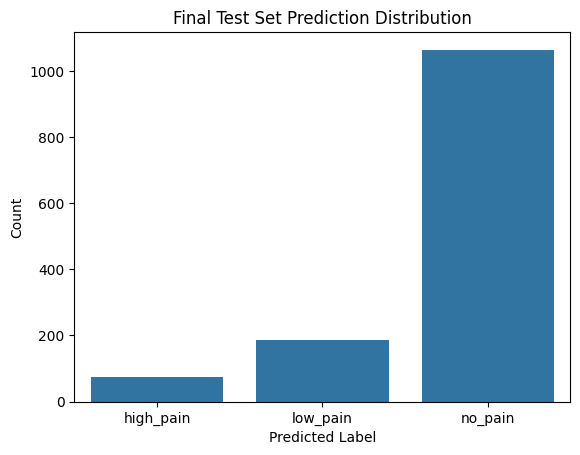


--- Top 5 Most Confused Samples (Smallest Confidence Margin) ---
              confidence_margin   no_pain  low_pain  high_pain
sample_index                                                  
1059                   0.008218  0.358437  0.274908   0.366655
562                    0.013437  0.471152  0.044259   0.484589
478                    0.028709  0.493470  0.041769   0.464761
764                    0.029457  0.513416  0.483959   0.002625
923                    0.039005  0.461450  0.038095   0.500455




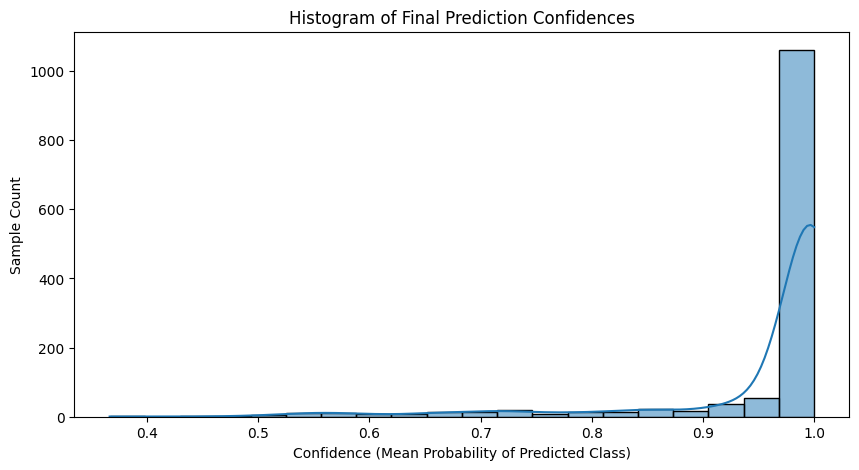


--- Plotting Window-by-Window Probabilities for Top 4 Most Confused Samples ---


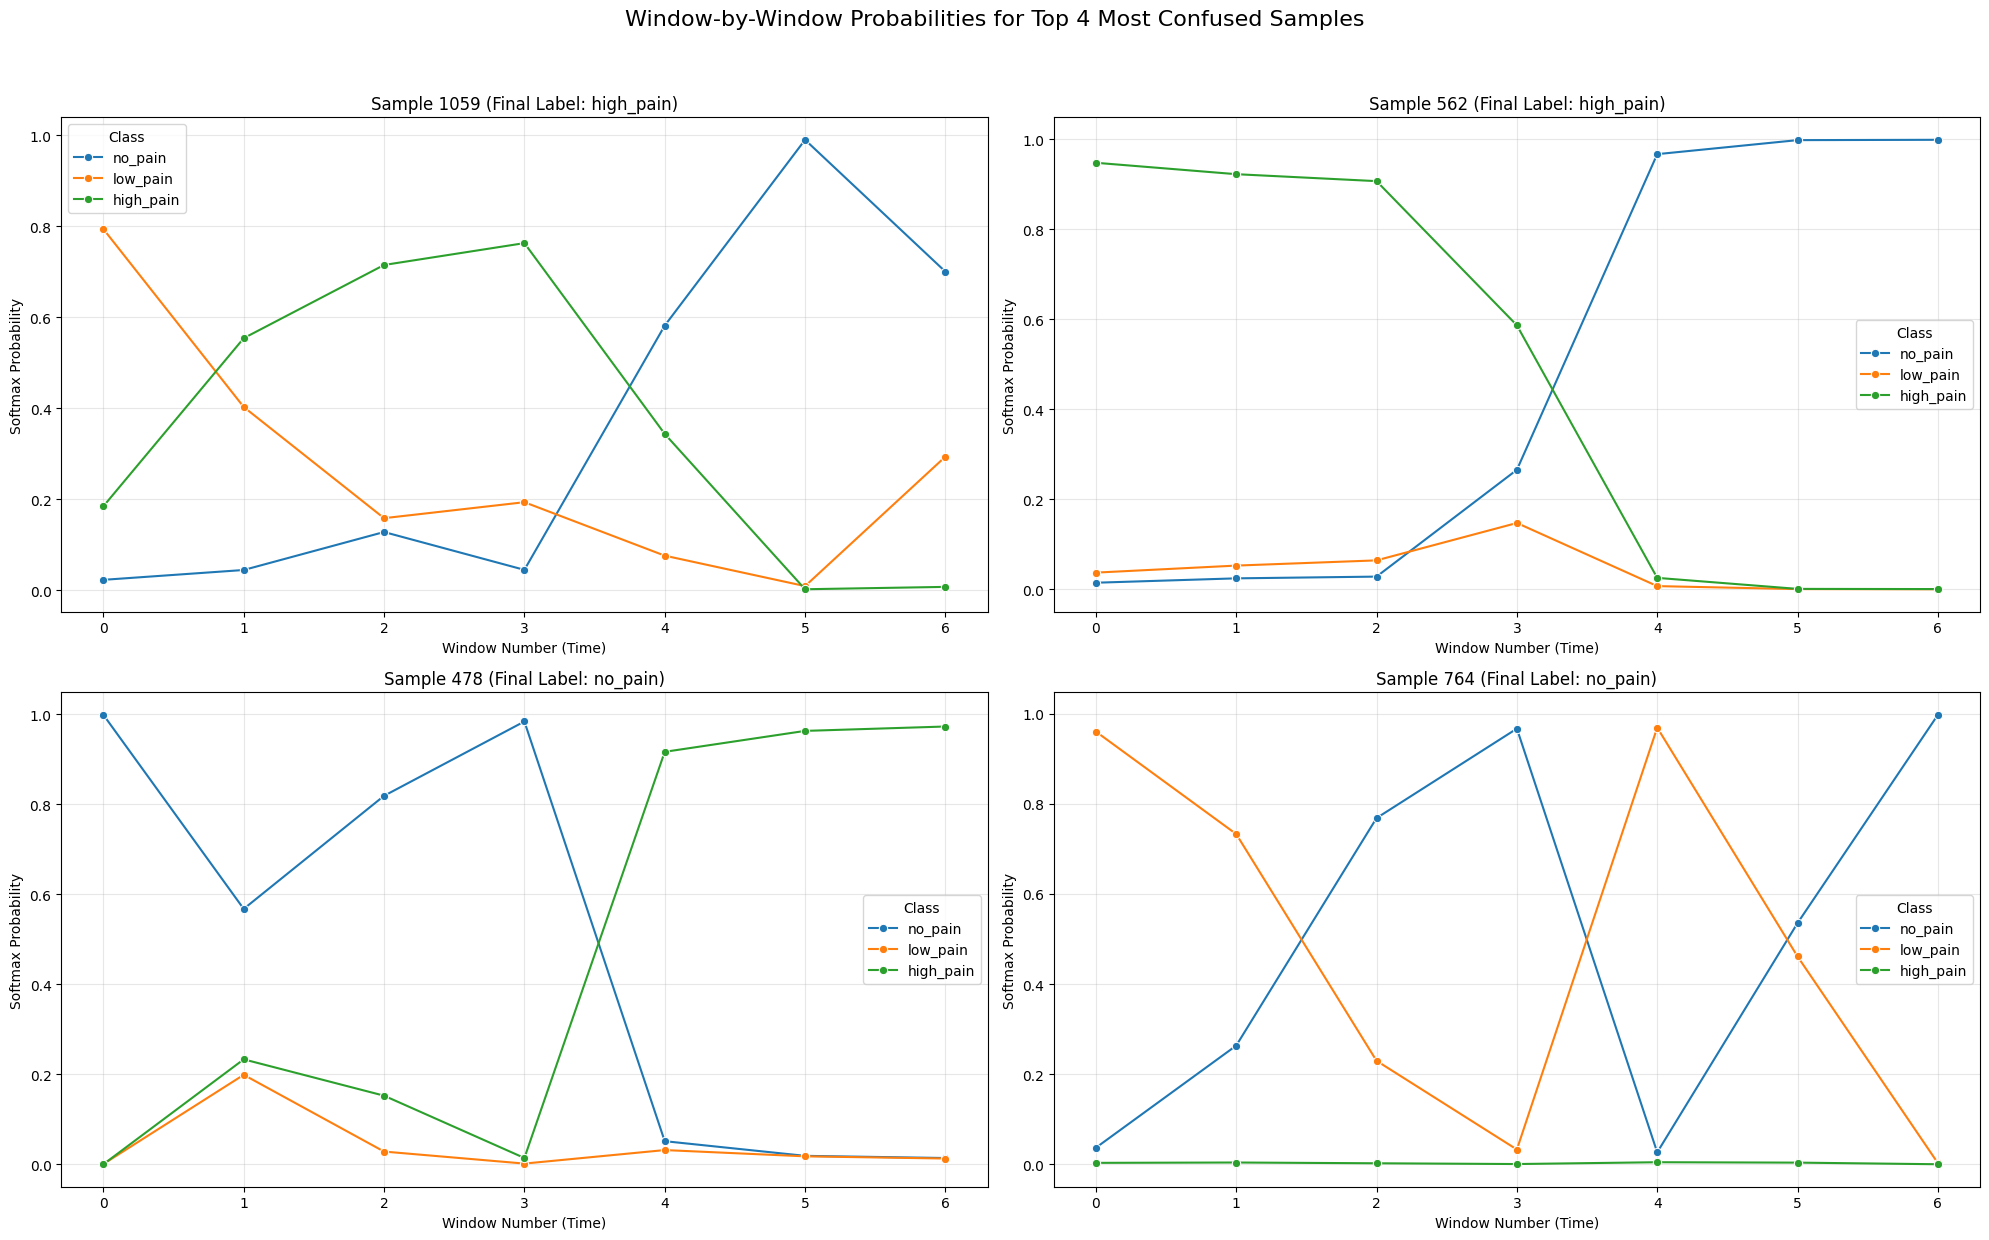


Prediction file saved successfully.


In [ ]:
# --- 7. Print and Plot Test Set Results ---
# (Plotting and summary logic is unchanged)
print("\n--- Final Test Set Predictions Summary ---")
print(submission_df['label'].value_counts(normalize=True))
print("\n---")

# Plot the distribution
# (Requires seaborn and matplotlib)
sns.countplot(x='label', data=submission_df, order=sorted(label_map.keys()))
plt.title('Final Test Set Prediction Distribution')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()

# --- 7b. Plot Final Prediction Confidence (HISTOGRAM) ---

# Get the mean probabilities for each class, for each sample
mean_probs_per_sample = df_window_scores.groupby('sample_index')[score_cols].mean()

# Get the *highest* mean probability (the confidence of the winning class)
final_confidences = mean_probs_per_sample.max(axis=1)


# --- Print Most Confused Samples ---
sorted_probs = np.sort(mean_probs_per_sample.values, axis=1)
top_1_probs = sorted_probs[:, -1]
top_2_probs = sorted_probs[:, -2]
mean_probs_per_sample['confidence_margin'] = top_1_probs - top_2_probs

print("\n--- Top 5 Most Confused Samples (Smallest Confidence Margin) ---")
print(mean_probs_per_sample.nsmallest(5, 'confidence_margin')[['confidence_margin'] + score_cols])
print("\n")

# Plot the histogram of these confidences
plt.figure(figsize=(10, 5))
sns.histplot(final_confidences, kde=True, bins=20)
plt.title('Histogram of Final Prediction Confidences')
plt.xlabel('Confidence (Mean Probability of Predicted Class)')
plt.ylabel('Sample Count')
plt.show()

most_confused_samples = mean_probs_per_sample.nsmallest(4, 'confidence_margin')
most_confused_indices = most_confused_samples.index

print(f"\n--- Plotting Window-by-Window Probabilities for Top {len(most_confused_indices)} Most Confused Samples ---")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
for ax, sample_to_plot in zip(axes.flatten(), most_confused_indices):
    
    final_label = submission_df[submission_df['sample_index'] == f"{int(sample_to_plot):03d}"]['label'].values[0]

    df_sample = df_window_scores[df_window_scores['sample_index'] == sample_to_plot]

    df_sample_melted = df_sample.reset_index(drop=True).rename_axis('window_num').reset_index()
    df_sample_melted = df_sample_melted.melt(id_vars=['window_num'], value_vars=score_cols, var_name='class_label', value_name='probability')

    sns.lineplot(data=df_sample_melted, x='window_num', y='probability', hue='class_label', marker='o', ax=ax)
    ax.set_title(f'Sample {sample_to_plot} (Final Label: {final_label})')
    ax.set_xlabel('Window Number (Time)')
    ax.set_ylabel('Softmax Probability')
    ax.legend(title='Class')
    ax.grid(alpha=0.3)

plt.suptitle('Window-by-Window Probabilities for Top 4 Most Confused Samples', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

# --- 8. Final Output File (Unchanged) ---
submission_df[['sample_index', 'label']].to_csv('pain_prediction_submission.csv', index=False)
print("\nPrediction file saved successfully.")

## Submission

In [ ]:
# --- 8. Save to CSV and TXT ---
os.makedirs("submissions", exist_ok=True)
os.makedirs("submissions_probs", exist_ok=True)

# 1. Save CSV (Final Labels - Original Request)
NAME_CSV_PREDICTION = f"submissions/submission_{experiment_name}.csv"
submission_df[['sample_index', 'label']].to_csv(NAME_CSV_PREDICTION, index=False)
print(f"Predictions saved to {NAME_CSV_PREDICTION}")

# 2. Prepare Data for TXT (Labels + Probabilities)
# df_txt uses mean_probs_per_sample (from the analysis cell) which contains the raw probabilities.

# Copy mean probabilities and ensure sample_index is a column
df_txt = mean_probs_per_sample.copy().reset_index()

# Merge the final label column (which is in submission_df)
df_txt['sample_index'] = df_txt['sample_index'].apply(lambda x: f"{int(x):03d}")

# Reorder columns: sample_index, final_label, prob_class1, prob_class2, ...
df_txt = df_txt.merge(submission_df[['sample_index', 'label']], on='sample_index', how='left')

df_txt = df_txt[['sample_index', 'label'] + score_cols]
# 3. Save TXT File (Include SEED in filename for traceability)
# Filename format: submission_probs_final_model_59_epochs_TIMESTAMP_SEED100.txt
NAME_TXT_PROBS = f"submissions_probs/submission_probs_{experiment_name}_SEED{SEED}.txt"

# Save using tab separator, without the index, and with the header
df_txt.to_csv(NAME_TXT_PROBS, sep='\t', index=False)
print(f"Probabilities saved to {NAME_TXT_PROBS}")

print(submission_df.head())

Predictions saved to submissions/submission_final_model_182_epochs_20251111_222337.csv
Probabilities saved to submissions_probs/submission_probs_final_model_182_epochs_20251111_222337_SEED100.txt
  sample_index    label
0          000  no_pain
1          001  no_pain
2          002  no_pain
3          003  no_pain
4          004  no_pain
